In [1]:
from itertools import product
from itertools import combinations

import os

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, ConcatDataset

import random
import ast
        

import torch.nn.functional as F
#from torcheval.metrics.functional import multiclass_confusion_matrix
from torch.optim import Adam ,SGD ,Adadelta
from torch.nn import CrossEntropyLoss

from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import transforms

import optuna

from itertools import product
from itertools import combinations
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation ,FFMpegWriter ,PillowWriter

import dill
import numpy as np

import json
import pandas as pd
from tqdm import tqdm
import copy
import os 
import random

from collections import OrderedDict
import wandb


In [2]:
#!pip install wandb

In [3]:
wandb.login(key="ab631efc36e2c87f5f54d82b5cdbd6c501d5221f")

wandb: Currently logged in as: aymentlili. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/crns/.netrc


True

In [4]:
import accelerate

In [5]:
#!accelerate config

In [6]:
seed=74
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
from Double_input_transformer import CustomDataset,TransformerAE

# Trainloader code

In [8]:

# Load the list
train_pair2 = np.load('train_pair++.npy', allow_pickle=True)
test_pair2 = np.load('test_pair++.npy', allow_pickle=True)
val_pair2 = np.load('val_pair++.npy', allow_pickle=True)
train_pair2 = [ list(x) for x in train_pair2]
test_pair2 = [ list(x) for x in test_pair2]
val_pair2 = [ list(x) for x in val_pair2]
random.shuffle(train_pair2)
random.shuffle(test_pair2)
random.shuffle(val_pair2)

In [9]:
def batchify(lst, batch_size):
    return [lst[i:i+batch_size] for i in range(0, len(lst), batch_size)]

# Example usage:
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
batch_size = 4
batches = batchify(my_list, batch_size)
print(batches)

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10]]


In [10]:
len(train_pair2),len(test_pair2),len(val_pair2)

(15822, 3743, 3871)

In [11]:
All = list(train_pair2)+list(test_pair2)+list(val_pair2)
All = [ list(x) for x in All]
All.sort(reverse=True)
len(All)

23436

In [12]:

# train_pair2=[]
# test_pair2=[]
# val_pair2=[]
# for i,L1 in tqdm(enumerate(All)) :
#     matches=[]
#     for L2 in All :
#         if L2[2]==4 and L2[3]==0 and L1[2]==4 and L1[3]==0 and L1[0]==L2[0] and L2 not in matches and L2 not in train_pair2 and L2 not in test_pair2  and L2 not in val_pair2 :
#             matches.append(L2)
#     train_pair2.extend(matches[:int(len(matches)*0.7)])
#     test_pair2.extend(matches[int(len(matches)*0.7):int(len(matches)*0.85)])
#     val_pair2.extend(matches[int(len(matches)*0.85):])
#     if L1[0]==[0,1,2,3,4,5,6,7] :
#         print(len(matches))
# print(len(train_pair2))
# print(len(test_pair2))
# print(len(val_pair2))

In [13]:
#cs_tr=CustomDataset(train_pair,batch_size=200)

In [14]:
#Dataset,EXP,ACC,U = cs_tr[0]
#x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]

In [15]:
#x1.shape
random.shuffle(train_pair2)
train_pair2[:2]

[[[0, 1, 6, 7, 9], [2, 5, 8], 4, 0], [[0, 4, 5, 6, 7, 8], [1, 9], 4, 0]]

In [16]:
# All = list(train_pair)+list(test_pair)+list(val_pair)
# All = [ list(x) for x in All]
# train_pair=[]
# test_pair=[]
# val_pair=[]
# for L1 in tqdm(All) :
#     matches=[]
#     for L2 in All :
#         if L1[0]==L2[0] and L2 not in matches and L2[2]==4 and L2[3]==0 :
#             matches.append(L2)
#     train_pair.extend(matches[:int(len(matches)*0.7)])
#     test_pair.extend(matches[int(len(matches)*0.7):int(len(matches)*0.85)])
#     val_pair.extend(matches[int(len(matches)*0.85):])

    

In [17]:
# val_pair=test_pair[int(len(test_pair)/2):]
# test_pair=test_pair[:int(len(test_pair)/2)]


In [18]:
val_pair2[0] ,len(train_pair2)

([[0, 1, 3], [2, 4, 5, 7], 4, 0], 15822)

In [19]:
# np.save("train_pair++", train_pair2)
# np.save("test_pair++", test_pair2)
# np.save("val_pair++", val_pair2)

# Autoencoder

In [20]:
#!pip install einops

In [21]:
class EmbedderNeuronGroup(nn.Module):
    def __init__(self, d_model, seed=22):
        super().__init__()
        #print("EmbedderNeuroneGroup")
        self.neuron_l1 = nn.Linear(200, d_model) #8
        self.neuron_l2 = nn.Linear(72, d_model) #12

    def forward(self, x):
        return self.multiLinear(x)

    def multiLinear(self, v):
        #print("multi-linear method",v.shape)

        l = []

        for ndx in range(8):
            idx_start = ndx * 200
            idx_end = idx_start + 200
            l.append(self.neuron_l1(v[:,idx_start:idx_end]))

        # l2
        for ndx in range(12):
            idx_start = 200*8 + ndx * 72
            idx_end = idx_start + 72
            l.append(self.neuron_l2(v[:,idx_start:idx_end]))
        #print(len(l))
        #print(len(l[0]))
        final = torch.stack(l, dim=1)

        # print(final.shape)
        return final



In [22]:
# max_seq_len=176,
# N=4
# heads=3
# d_model=900
# d_ff=900
# neck=700
# dropout=0.1
# # Enc=EncoderNeuronGroup(d_model=d_model, N=N, heads=heads, max_seq_len=max_seq_len, dropout=dropout,d_ff=d_ff)
# # vec1 = torch.rand(1,2464)
# # res,scores=Enc(vec1)
# # res.shape

In [23]:
# vec2neck = nn.Linear(d_ff*2, neck)
# print(res.shape)
# out3=torch.cat([res,res], dim=2)
# print("neck input:",out3.shape)
# sum_r=torch.sum(out3, dim=1, keepdim=False)
# vec2=vec2neck(sum_r)
# print(len(vec2))
# tanh = nn.Tanh()
# neck_t=tanh(vec2)
# print("neck shape:",neck_t.shape)

In [24]:
# Dec=DecoderNeuronGroup(d_model=d_model, N=N, heads=heads, max_seq_len=max_seq_len, dropout=dropout,d_ff=d_ff,neck=neck)
# res,scores=Dec(neck_t)
# res.shape

In [25]:
len(test_pair2),len(train_pair2),len(val_pair2)#,len(test_tgt),len(train_tgt),len(val_tgt)

(3743, 15822, 3871)

In [26]:
#test_pair=[ x for x in test_pair  if (0 in x[0]) and (1 in x[0]) and (2 in x[0] or 2 in x[1] ) and (3 in[0] or 2 in x[1]) and (4 in[0] or 2 in x[1] ) ]
#len(test_pair)

In [27]:
from torchvision import datasets
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

class ClassSpecificImageFolder(datasets.DatasetFolder):
    def __init__(
            self,
            root,
            dropped_classes=[],
            transform = None,
            target_transform = None,
            loader = datasets.folder.default_loader,
            is_valid_file = None,
    ):
        self.dropped_classes = dropped_classes
        super(ClassSpecificImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                                       transform=transform,
                                                       target_transform=target_transform,
                                                       is_valid_file=is_valid_file)
        self.imgs = self.samples

    def find_classes(self, directory):
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        classes = [c for c in classes if c not in self.dropped_classes]
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [28]:


# print(mod.numParams())
# x1 = torch.rand(1,2464)
# x2 = torch.rand(1,2464)
# mod=mod.to(device).to(torch.float32)

# #x1=x1.to(torch.float32)
# #x2=x2.to(torch.float32)
# x1=x1.to(device)
# x2=x2.to(device)
# mod=mod.to(device)
# out = mod(x1,x2)
# print("Output Shape: ", out[0].shape)

# from torchinfo import summary

# summary(mod)


In [29]:


#from torcheval.metrics.functional import multiclass_confusion_matrix

class CNN(nn.Module):
    def __init__(
        self,
        channels_in,
        nlin="leakyrelu",
        dropout=0.0,
        init_type="uniform",
    ):
        super().__init__()
        # init module list
        self.module_list = nn.ModuleList()
        ### ASSUMES 28x28 image size
        ## compose layer 1
        self.module_list.append(nn.Conv2d(channels_in, 8, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        # apply dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 2
        self.module_list.append(nn.Conv2d(8, 6, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 3
        self.module_list.append(nn.Conv2d(6, 4, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add flatten layer
        self.module_list.append(nn.Flatten())
        ## add linear layer 1
        self.module_list.append(nn.Linear(3 * 3 * 4, 20))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## add linear layer 1
        self.module_list.append(nn.Linear(20, 10))

        ### initialize weights with se methods
        self.initialize_weights(init_type)

    def initialize_weights(self, init_type):
        # print("initialze model")
        for m in self.module_list:
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                if init_type == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                if init_type == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                if init_type == "uniform":
                    torch.nn.init.uniform_(m.weight)
                if init_type == "normal":
                    torch.nn.init.normal_(m.weight)
                if init_type == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight)
                if init_type == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight)
                # set bias to some small non-zero value
                m.bias.data.fill_(0.01)

    def get_nonlin(self, nlin):
        # apply nonlinearity
        if nlin == "leakyrelu":
            return nn.LeakyReLU()
        if nlin == "relu":
            return nn.ReLU()
        if nlin == "tanh":
            return nn.Tanh()
        if nlin == "sigmoid":
            return nn.Sigmoid()
        if nlin == "silu":
            return nn.SiLU()
        if nlin == "gelu":
            return nn.GELU()


    def forward(self, x):
        # forward prop through module_list
        for layer in self.module_list:
            x = layer(x)
        return x

    def forward_activations(self, x):
        # forward prop through module_list
        activations = []
        for layer in self.module_list:
            x = layer(x)
            if (
                isinstance(layer, nn.Tanh)
                or isinstance(layer, nn.Sigmoid)
                or isinstance(layer, nn.ReLU)
                or isinstance(layer, nn.LeakyReLU)
                or isinstance(layer, nn.SiLU)
                or isinstance(layer, nn.GELU)
                or isinstance(layer, ORU)
                or isinstance(layer, ERU)
            ):
                activations.append(x)
        return x, activations
def train(model, trainloader, optimizer, criterion,nb_classes,First=False,df=None,verbose=False,log_freq_steps=25):
    List_mx=[]
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image
        labels = labels
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        #mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
        #List_mx.append(mx)
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
        if First==True and i%log_freq_steps==0 :
            epoch_loss = train_running_loss / counter
            epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
            if verbose==True:
                print(epoch_acc,"%")
            #print(f"step {i}:",epoch_loss, epoch_acc)
            if df!=None:
                df.at[track,f"Step {i}"]=epoch_acc
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc,List_mx


def validate(model, testloader, criterion,nb_classes):
    List_mx=[]
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            if data is None:  # Skip None values
                continue
            counter += 1
            
            image, labels = data
            image = image
            labels = labels
            # forward pass
            outputs = model(image)#.to(torch.float32)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            #mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
            #List_mx.append(mx)
            
            
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc,List_mx
def create_frame(step,ax,data):
    ax=ax.cla()
    sns.heatmap(data[step][-1].cpu(),annot=True,cmap="cubehelix",ax=ax,cbar=False)
    plt.title('Epoch {} training {}'.format(step,exp)  )

In [30]:
#L_activations=["gelu","relu","silu","leakyrelu","sigmoid","tanh"]
#csv_files,L_activations

In [31]:
#(2) in https://arxiv.org/pdf/2209.14733.pdf
vec1 = torch.rand(1,2464)
vec2 = torch.rand(1,2464)
class LWLN_loss(nn.Module):
    def __init__(self):
        super(LWLN_loss, self).__init__()
    def forward(self, vec1,vec2):
        loss = (torch.mean((vec1[:,0:208]-vec2[:,0:208])**2)/vec2[:,0:208].std() + 
                 torch.mean((vec1[:,208:1414]-vec2[:,208:1414])**2)/vec2[:,208:1414].std()+ 
                 torch.mean((vec1[:,1414:1514]-vec2[:,1414:1514])**2)/vec2[:,1414:1514].std()+
                 torch.mean((vec1[:,1514:2254]-vec2[:,1514:2254])**2)/vec2[:,1514:2254].std()+
                 torch.mean((vec1[:,2254:2464]-vec2[:,2254:2464])**2)/vec2[:,2254:2464].std())/(6)
        
        return loss
LW=LWLN_loss()
LW(vec1,vec2)

tensor(0.4551)

In [32]:
Cols=["label task 1","index","Accuracy task1",\
      "label task 2","Accuracy task2"]+ \
["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]+ \
["Loader Set","Reconstructed Accuracy ID","Actual Accuracy","Reconstructed Accuracy OOD","Transformer Loss","lr",'epochCNN','ActivationCNN'] 

print(len(Cols))
predicted_Weights= pd.DataFrame(columns=Cols)

# row=["".format(task1),int(ind[0]),ACC[0],"".format(task2),ACC[1]]+vector_aux.to_list()+["train",valid_epoch_acc0,ACC[2],valid_epoch_acc1,L_train[-1]]
# predicted_Weights.append(row, ignore_index=True)
predicted_Weights

2477


,label task 1,index,Accuracy task1,label task 2,Accuracy task2,weight 0,weight 1,weight 2,weight 3,weight 4,...,bias 2462,bias 2463,Loader Set,Reconstructed Accuracy ID,Actual Accuracy,Reconstructed Accuracy OOD,Transformer Loss,lr,epochCNN,ActivationCNN


# Training 

In [33]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)
def scheduler_to(sched, device):
    for param in sched.__dict__.values():
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)

In [34]:
import datetime
print(datetime.datetime.now())

2024-08-22 13:08:53.144447


In [35]:
from torch.autograd import Variable
def loss_Contractive(W, x, recons_x, h, lam):
    dh = h * (1 - h) 

    w_sum = torch.sum(Variable(W)**2, dim=1)

    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
 
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)

    return contractive_loss.mul_(lam)

vec1 = torch.rand(1,2464)
vec2 = torch.rand(1,2464)
#print(out[1].shape,W.shape)
# for name, param in mod.named_parameters():
#     if name == 'vec2neck.weight':
#         W = param
#         break
# CL=loss_Contractive(W,vec1,vec2, out[1], 0.005)

# CL

In [36]:
vec1 = torch.rand(5,2464)
vec2 = torch.rand(5,2464)
from scipy.stats import wasserstein_distance
# Convert to numpy arrays
vec1_np = vec1.numpy()
vec2_np = vec2.numpy()

# Compute Wasserstein distance for each pair of vectors
wsd_list = [wasserstein_distance(vec1_np[i], vec2_np[i]) for i in range(vec1_np.shape[0])]

# If you need an aggregate measure, you can compute the average distance
average_wsd = sum(wsd_list) / len(wsd_list)


In [37]:
def q_quantile_loss(pred, target, q):
    error = target - pred
    return torch.mean(torch.max(q * error, (q - 1) * error))

def frobenius_norm_jacobian(model, x1,x2):
    x1 = x1.clone().detach().requires_grad_(True)
    x2 = x2.clone().detach().requires_grad_(True)
    y = model(x1,x2)
    jacobian = []
    for i in range(y[0].shape[0]):
        grad_outputs = torch.zeros_like(y[0])
        grad_outputs[:, i] = 1
        grad = torch.autograd.grad(outputs=y[0], inputs=(x1,x2), grad_outputs=grad_outputs,
                                   retain_graph=True, create_graph=True)[0]
        jacobian.append(grad)
    jacobian = torch.stack(jacobian, dim=1)
    frobenius_norm = torch.norm(jacobian, p='fro')
    return frobenius_norm.detach().item()

# mod= TransformerAE(max_seq_len=50,
#                         N=4,
#                         heads=4,
#                         d_model=40,
#                         d_ff=40,
#                         neck=25,
#                         dropout=0.12
#                        )
# mod=mod.cuda()
# vec1 = torch.rand(5,2464)
# vec2 = torch.rand(5,2464)
# vec1=vec1.cuda()
# vec2=vec2.cuda()
# output=mod(vec1,vec2)
# print(output[0].shape)
# print(frobenius_norm_jacobian(mod, vec1,vec2))

# 0.15*frobenius_norm_jacobian(mod, vec1,vec2)+q_quantile_loss(output[0],vec1,0.9)

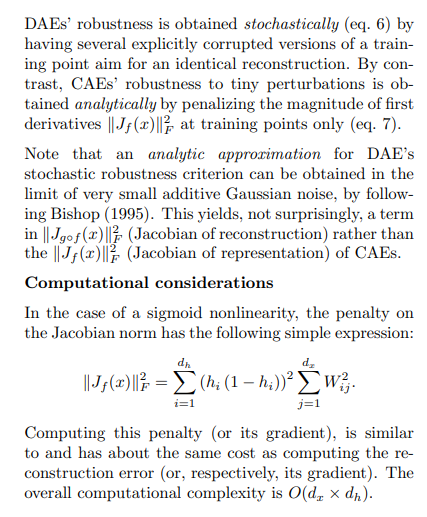

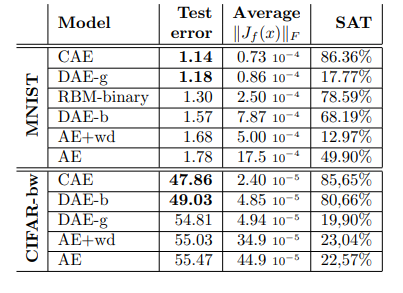

In [38]:
%%time
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad

def kernel_density_estimate(vector):
    kde = gaussian_kde(vector)
    return kde

def finite_difference_gradient(x, kde, h=1e-5):
    pdf_value_plus_h = kde.evaluate(x + h)
    pdf_value_minus_h = kde.evaluate(x - h)
    gradient = (np.log(pdf_value_plus_h) - np.log(pdf_value_minus_h)) / (2 * h)
    return gradient

def score_function(x, kde):
    return finite_difference_gradient(x, kde)

def fisher_information_integral(kde, xmin, xmax):
    def integrand(x):
        score = score_function(x, kde)
        return score**2
    
    fisher_info, _ = quad(integrand, xmin, xmax)
    return fisher_info

def fisher_information(vector):
    kde = kernel_density_estimate(vector)
    xmin, xmax = np.min(vector), np.max(vector)
    fisher_info = fisher_information_integral(kde, xmin, xmax)
    return fisher_info

def fisher_information_difference(vec1, vec2):
    fisher_info_1 = fisher_information(vec1)
    fisher_info_2 = fisher_information(vec2)
    
    fisher_info_diff = np.abs(fisher_info_1 - fisher_info_2)
    return fisher_info_diff

# Example vectors
    # vec1 = np.random.randn(1000)
    # vec2 = np.random.randn(1000)
    # fisher_info_diff = fisher_information_difference(vec1, vec2)
vec1 = torch.rand(80,2464)
vec2 = torch.rand(80,2464)

vec1_np = vec1.detach().cpu().numpy()
vec2_np = vec2.detach().cpu().numpy()
wsd_list = [fisher_information_difference(vec1_np[i,:], vec2_np[i,:])
            +np.log(abs(np.sum(np.abs(vec1_np[i,:])-np.sum(np.abs(vec2_np[i,:])))))
            for i in range(vec1_np.shape[0])]
average_FIM_N1_Loss= sum(wsd_list) / len(wsd_list)
average_FIM_N1_Loss
###loss_tr = criterion(output[0],tg)+average_wsd

CPU times: user 23.1 s, sys: 1min 4s, total: 1min 27s
Wall time: 7.65 s


16.028878711335295

In [ ]:
!pip install pykeops
!pip install geomloss

In [39]:
vec1[0,:]

tensor([0.6141, 0.0585, 0.8322,  ..., 0.2039, 0.2994, 0.2566])

In [49]:
import torch
from geomloss import SamplesLoss
vec1 = torch.rand(1,2464)
vec2 = torch.rand(1,2464)
LossWS=SamplesLoss('sinkhorn')

from scipy.stats import wasserstein_distance
# Convert to numpy arrays
vec1_np = vec1[0].numpy()
vec2_np = vec2[0].numpy()
print(LossWS(vec1,vec2), wasserstein_distance(vec1_np,vec2_np))

tensor(205.0541) 0.010327264352084755


In [40]:
# Turn off optuna log notes.
optuna.logging.set_verbosity(optuna.logging.WARN)


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [41]:
### Imports
from collections import deque
from typing import Dict, Optional, Literal
import torch
import torch.nn as nn


### Grokfast
def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.99,
    lamb: float = 5.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad}

    for n, p in m.named_parameters():
        if p.requires_grad:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads


### Grokfast-MA
def gradfilter_ma(
    m: nn.Module,
    grads: Optional[Dict[str, deque]] = None,
    window_size: int = 128,
    lamb: float = 5.0,
    filter_type: Literal['mean', 'sum'] = 'mean',
    warmup: bool = True,
    trigger: bool = False,
) -> Dict[str, deque]:
    if grads is None:
        grads = {n: deque(maxlen=window_size) for n, p in m.named_parameters() if p.requires_grad}

    for n, p in m.named_parameters():
        if p.requires_grad:
            grads[n].append(p.grad.data.detach())

            if not warmup or len(grads[n]) == window_size and not trigger:
                if filter_type == "mean":
                    avg = sum(grads[n]) / len(grads[n])
                elif filter_type == "sum":
                    avg = sum(grads[n])
                else:
                    raise ValueError(f"Unrecognized filter_type {filter_type}")
                p.grad.data = p.grad.data + avg * lamb

    return grads

# Training loop

In [41]:
import random
import csv 
import time
import sys
import time
import datetime
import warnings
import traceback
import gc
from accelerate import Accelerator


track=0

from torchinfo import summary

# 

warnings.filterwarnings("ignore")


#from optuna.storages import JournalStorage, JournalFileStorage

#storage = JournalStorage(JournalFileStorage("optuna-journal DDP 3 Losses.log"))

#def objective(trial):
global track , output , model
grads=None
accelerator = Accelerator()
Loss="LWLN" #trial.suggest_categorical("Loss function",["MSE"])#,"LWLN","Contractive",])
Lambda=0
if Loss=="MSE":
    results_path="/media/crns/ADATA HD330/Experiments/model MSE/"
if Loss=="Contractive":
    results_path="./Contractive model/"
    Lambda=0 #trial.suggest_float("Contractive_Lambda",0.00001,0.0001)
if Loss=="LWLN":
    results_path="/media/crns/ADATA HD330/Experiments//mixed model/"

cnn_acc_ID=[]
cnn_acc_OOD=[]

step_size=0
factor=0
threshhold=0
threshold_mode = 0
eps=0

minimal_loss=1000
#alpha = trial.suggest_float("grokalpha",0.0,1.0)
#lamb = trial.suggest_int("groklamb",1,15)
mod= TransformerAE(max_seq_len=50,
                        N=4,
                        heads=4,
                        d_model=940,
                        d_ff=940,
                        neck=256,
                        dropout=0.12
                       ) #define_model(trial)
print(summary(mod))
lrE1=0.15 #trial.suggest_float("Learning_rate",0.0002,0.5)
lrE2=0.15 
lrL=0.15 
lrD=0.085
optimizerEnc1 = Adam(mod.parameters(), lr=lrE1,eps=1e-10,weight_decay=0.005)
optimizerEnc2 = Adadelta(mod.parameters(), lr=lrE2,eps=1e-10,weight_decay=0.005)
optimizerDense = SGD(mod.vec2neck.parameters(), lr=lrL,weight_decay=0.005)
optimizerDec = Adadelta(mod.parameters(), lr=lrD,eps=1e-10,weight_decay=0.01)



sched_name="CyclicLR"#trial.suggest_categorical("scheduler",["CyclicLR"])#,"ReduceLROnPlateau"])
if sched_name=="CyclicLR" :
    step_size=24000#trial.suggest_int("step_size_up",900,2800)
    schedulerEnc1 = torch.optim.lr_scheduler.CyclicLR(optimizerEnc1, base_lr=1e-4, max_lr=lrE1, step_size_up=step_size, step_size_down=80000,scale_mode="iterations",mode="triangular2",cycle_momentum=False)
    schedulerEnc2 = torch.optim.lr_scheduler.CyclicLR(optimizerEnc2, base_lr=1e-4, max_lr=lrE2, step_size_up=step_size, step_size_down=80000,scale_mode="iterations",mode="triangular2",cycle_momentum=False)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizerDense, base_lr=1e-4, max_lr=lrD, step_size_up=8000, step_size_down=8000,scale_mode="iterations",mode="triangular",cycle_momentum=False)
    
    
# if sched_name=="ReduceLROnPlateau" :
#     factor=trial.suggest_float("R-lr-OP_factor",0.001,0.5)
#     threshhold=trial.suggest_float("R-lr-OP_threshhold",0.0001,0.001)
#     threshold_mode = trial.suggest_categorical("thresh_mod",["rel","abs"])
#     eps=trial.suggest_float("R-lr-OP_eps",1e-08,1e-05)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=5, threshold=threshhold, threshold_mode=threshold_mode, cooldown=2, min_lr=0, eps=eps)



# ch=torch.load("/media/crns/ADATA HD330/Experiments/mixed model/AE epoch 0 600.pth")
# resume_epoch=ch["epoch"]
# mod.load_state_dict(ch['model_state_dict'])
# optimizerEnc1.load_state_dict(ch['optimizerENC1_state_dict'])
# optimizerEnc2.load_state_dict(ch['optimizerENC2_state_dict'])
# optimizerDense.load_state_dict(ch['optimizerDense_state_dict'])
# optimizerDec.load_state_dict(ch['optimizerDec_state_dict'])

# del(ch)


batch_size=50 #trial.suggest_int("batch_size",150)

criterion = nn.MSELoss()
LW=LWLN_loss()

num_epochs=1000

device = accelerator.device
run = wandb.init(
# Set the project where this run will be logged
project="aymen-project",
name= f"Shuffled 100%(activation,age) data,new paperarch-{Loss} .. Fischer information + log(norm)" ,
# Track hyperparameters and run metadata
config={
    "Loss":Loss,
    "lr Encoder 1": lrE1,
    "lr Encoder 2": lrE2,
    "lr Linear": lrL,
    "lr Decoder": lrD,
    "epochs": num_epochs,
    "sched_name": sched_name,
    "step_size": step_size,
    "batch_size": batch_size,
    "step_size":step_size,
    "Lambda_contractive":Lambda
},)

#run = wandb.init(project="aymen-project", id="y7pm5vwk", resume="must")

# "factor":factor,
#     "threshhold":threshhold,
#     "threshold_mode":threshold_mode,
#     "eps":eps,
random.shuffle(train_pair2)
cs_tr=CustomDataset(train_pair2,batch_size=batch_size)
nb_batches = len(cs_tr)//batch_size

cs_val=CustomDataset(val_pair2,batch_size=batch_size)
nb_val_batches = len(cs_val)//batch_size

#optimizer_to(optimizer,device)
#scheduler_to(scheduler,device)

#mod, optimizerEnc1,optimizerEnc2,optimizerDense,optimizerDec, cs_tr= accelerator.prepare(mod, optimizerEnc1,optimizerEnc2,optimizerDense,optimizerDec,cs_tr)
# wandb.watch(mod, log_freq=10000 ,criterion=criterion,
#     log='parameters',
#     log_graph=True)
mod.train()
for epoch in range(0,num_epochs):
    random.shuffle(train_pair2)
    cs_tr=CustomDataset(train_pair2,batch_size=batch_size)
    cs_tr=accelerator.prepare(cs_tr)
    #start_time_epoch = time.time()
    for i in tqdm(range(nb_batches)):
        #start_time_batch = time.time()
        Dataset,EXP,ACC,U = cs_tr[i]
        x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]
        # if (Loss=="Contractive") and (i%50==0):
        #     for name, param in mod.named_parameters():
        #         if name == 'vec2neck.weight':
        #             W = param
        #             break


        x1=x1.cuda() #.to(torch.float32)
        x2=x2.cuda() #.to(torch.float32)
        tg=tg.cuda() #.to(torch.float32)

        optimizerEnc1.zero_grad()
        optimizerEnc2.zero_grad()
        optimizerDense.zero_grad()
        optimizerDec.zero_grad()

        output = mod(x1,x2)

        #print(output[2].shape ,output[3].shape,output[4].shape) 
        # if Loss=="MSE":
        #     loss_tr = criterion(output[0],tg)
        # if Loss=="Contractive":
        #     CL=loss_Contractive(W,vec1,vec2, output[1], Lambda)
        #     loss_tr = criterion(output[0],tg)+CL
        if Loss=="LWLN":
            # vec1_np = output[0].detach().cpu().numpy()
            # vec2_np = tg.detach().cpu().numpy()
            # wsd_list = [wasserstein_distance(vec1_np[i], vec2_np[i]) for i in range(vec1_np.shape[0])]
            # average_wsd = sum(wsd_list) / len(wsd_list)
            ### loss_tr = criterion(output[0],tg)+average_wsd
            
            
            #fnj=frobenius_norm_jacobian(mod, x1,x2).cuda()
            #qql=q_quantile_loss(output[0],tg,0.9).cuda()
            ###loss_tr=0.15*fnj+qql
            
            vec1_np = output[0].detach().cpu().numpy()
            vec2_np = tg.detach().cpu().numpy()
            fid_values = np.array([fisher_information_difference(vec1_np[i, :], vec2_np[i, :]) for i in range(vec1_np.shape[0])])
            abs_diff_sum = np.sum(np.abs(vec1_np), axis=1) - np.sum(np.abs(vec2_np), axis=1)
            log_abs_sum_diff = np.log(np.abs(abs_diff_sum))
            wsd_list = fid_values + log_abs_sum_diff
            average_FIM_N1_Loss = np.mean(wsd_list)
            loss_tr = criterion(output[0], tg) + average_FIM_N1_Loss
            time_batch = time.time()
            
            # wsd_list = [fisher_information_difference(vec1_np[i,:], vec2_np[i,:])
            #             +np.log(abs(np.sum(np.abs(vec1_np[i,:])-np.sum(np.abs(vec2_np[i,:])))))
            #             for i in range(vec1_np.shape[0])]
            # average_FIM_N1_Loss= sum(wsd_list) / len(wsd_list)
            # loss_tr = criterion(output[0],tg)+average_FIM_N1_Loss
            
            
#         except Exception as e:
#             # Print the exception
#             print("An exception occurred:", e)
#             traceback.print_exc()
#             # Continue with the loop
#             continue


        #accelerator.backward(loss_tr)
        loss_tr.backward()
        #grads = gradfilter_ema(mod, grads=grads, alpha=alpha, lamb=lamb)
        optimizerEnc1.step()
        optimizerEnc2.step()
        optimizerDense.step()
        optimizerDec.step()
        if sched_name=="ReduceLROnPlateau" :
            scheduler.step(loss_tr)
        else:
            scheduler.step()
            schedulerEnc1.step()
            schedulerEnc2.step()
        
        loss_to_save = float(loss_tr.detach().cpu().item())
        wandb.log({"Loss":loss_to_save})
    if loss_tr.detach().cpu().item()<minimal_loss:
        minimal_loss=loss_tr.detach().cpu().item()
        torch.save({'epoch':epoch,'model_state_dict': mod.state_dict(),
                    'optimizerENC1_state_dict':  optimizerEnc1.state_dict() ,
                    'optimizerENC2_state_dict':optimizerEnc2.state_dict(),
                    'optimizerDense_state_dict':optimizerDense.state_dict(),
                    'optimizerDec_state_dict': optimizerDec.state_dict(),
                    'Batch Loss':loss_tr.detach().cpu().item()},
                   results_path+'AE epoch best.pth')
    if epoch%30==0 :
        for block in [2,3,4]:
                for head in range(4):
                    plt.figure(figsize=(20, 20))
                    hm=sns.heatmap(torch.mean( torch.mean(output[block][head], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
                    plt.title('Attention Heatmap')
                    heatmap_path = f'heatmap {block-2}_{head}_step_{i}.png'
                    #plt.savefig(results_path+"Attention/"+heatmap_path)#,format='svg', dpi=800)
                    wandb.log({f"attention_heatmap {block-2}_{head}":  wandb.Image(hm,caption=f"attention_heatmap attention_heatmap {block-2}_{head}")})
                    plt.close()
        mod.eval()
        loss_val = []
        for i_val in range(nb_val_batches):
            #start_time_batch = time.time()
            Dataset_val,EXP_val,ACC_val,U_val = cs_val[i_val]
            x1_val,x2_val,tg_val = Dataset_val[:,0,:], Dataset_val[:,1,:],Dataset_val[:,2,:]
            x1_val=x1_val.cuda() #.to(torch.float32)
            x2_val=x2_val.cuda() #.to(torch.float32)
            tg_val=tg_val.cuda() #.to(torch.float32)
            with torch.no_grad():
                #output_val = mod(x1_val,x2_val)
                loss_val.append(criterion(mod(x1_val,x2_val)[0],tg_val))
        loss_val = sum(loss_val)/len(loss_val)
        wandb.log({f"val_loss":loss_val})
            
        torch.save({'epoch':epoch,'model_state_dict': mod.state_dict(),
                    'optimizerENC1_state_dict':  optimizerEnc1.state_dict() ,
                    'optimizerENC2_state_dict':optimizerEnc2.state_dict(),
                    'optimizerDense_state_dict':optimizerDense.state_dict(),
                    'optimizerDec_state_dict': optimizerDec.state_dict(),
                    'Batch Loss':loss_tr.detach().cpu().item()},
                   results_path+'AE epoch {} {}.pth'.format(track,epoch))
        torch.cuda.empty_cache()
wandb.finish()
track=+1
#     return loss_tr
# study= optuna.create_study(direction="minimize",storage=storage)
# study.optimize(objective,n_trials=2,callbacks=[lambda study, trial: gc.collect()]+[logging_callback])

encoder droupout init 0.12
encoder droupout init 0.12
decoder droupout init 0.12
Layer (type:depth-idx)                             Param #
TransformerAE                                      --
├─EncoderNeuronGroup: 1-1                          --
│    └─EmbedderNeuronGroup: 2-1                    --
│    │    └─Linear: 3-1                            15,980
│    │    └─Linear: 3-2                            76,140
│    └─PositionalEncoder: 2-2                      --
│    └─ModuleList: 2-3                             --
│    │    └─EncoderLayer: 3-3                      5,311,000
│    │    └─EncoderLayer: 3-4                      5,311,000
│    │    └─EncoderLayer: 3-5                      5,311,000
│    │    └─EncoderLayer: 3-6                      5,311,000
│    └─Norm: 2-4                                   1,880
├─EncoderNeuronGroup: 1-2                          --
│    └─EmbedderNeuronGroup: 2-5                    --
│    │    └─Linear: 3-7                            15,980
│    │ 

  0%|          | 1/316 [00:42<3:40:45, 42.05s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/crns/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12664/3871012138.py", line 195, in <module>
    fid_values = np.array([fisher_information_difference(vec1_np[i, :], vec2_np[i, :]) for i in range(vec1_np.shape[0])])
  File "/tmp/ipykernel_12664/3871012138.py", line 195, in <listcomp>
    fid_values = np.array([fisher_information_difference(vec1_np[i, :], vec2_np[i, :]) for i in range(vec1_np.shape[0])])
  File "<timed exec>", line 33, in fisher_information_difference
  File "<timed exec>", line 29, in fisher_information
  File "<timed exec>", line 23, in fisher_information_integral
  File "/home/crns/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py", line 464, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
  File "/home/crns/anaconda3/lib/python3.9/site-pack

TypeError: object of type 'NoneType' has no len()

Testing loop :
```[tasklist]
### track MSE 
- [ ] add Classification report for 1 CNN
- [ ] per layer MSE
- [ ] Deeplift
- [ ] Grackel
### Loss functions + apply per layer
- [ ] KL divergence
- [ ] Wassertsiein
- [ ] dataset distance
- [ ] Layerwise normalisations
- [ ] Cook's distance 
### Track weights and their saturation
- [ ] Contractive
- [ ] L2
- [ ] saturated percentage
- [ ] Experiment with pruning the CNNs
### Topology of learned weights
- [ ] Reebs + Smole complex
- [ ] Persistant homolgy
```

In [39]:
Cols=["label task 1","label task 2"]+ \
["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]+ \
["Pred weight {}".format(x) for x in range(200)]+["Pred bias {}".format(x) for x in range(200,208)]+ \
["Pred weight {}".format(x) for x in range(208,1408)]+["Pred bias {}".format(x) for x in range(1408,1414)]+ \
["Pred weight {}".format(x) for x in range(1414,1510)]+["Pred bias {}".format(x) for x in range(1510,1514)]+ \
["Pred weight {}".format(x) for x in range(1514,2234)]+["Pred bias {}".format(x) for x in range(2234,2254)]+ \
["Pred weight {}".format(x) for x in range(2254,2454)]+["Pred bias {}".format(x) for x in range(2454,2464)]+ \
["FN weight {}".format(x) for x in range(200)]+["FN bias {}".format(x) for x in range(200,208)]+ \
["FN weight {}".format(x) for x in range(208,1408)]+["FN bias {}".format(x) for x in range(1408,1414)]+ \
["FN weight {}".format(x) for x in range(1414,1510)]+["FN bias {}".format(x) for x in range(1510,1514)]+ \
["FN weight {}".format(x) for x in range(1514,2234)]+["FN bias {}".format(x) for x in range(2234,2254)]+ \
["FN weight {}".format(x) for x in range(2254,2454)]+["FN bias {}".format(x) for x in range(2454,2464)]+ \
["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KLD","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
["WSD FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\
["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]
#incoporate Norm                                                     
#The Fisher information metric X norm of the target  
#dataset distance , topological distance ,UMAP distance

print(len(Cols))
DF= pd.DataFrame(columns=Cols)

# row=["".format(task1),int(ind[0]),ACC[0],"".format(task2),ACC[1]]+vector_aux.to_list()+["train",valid_epoch_acc0,ACC[2],valid_epoch_acc1,L_train[-1]]
# predicted_Weights.append(row, ignore_index=True)


7485


In [39]:
#!pip install numpy==1.23

In [40]:
#!pip install scipy==1.12

In [41]:
# ["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
# ["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
# ["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
# ["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
# ["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]
class LWLN_loss(nn.Module):
    def __init__(self):
        super(LWLN_loss, self).__init__()
    def forward(self, vec1,vec2):
        loss = (torch.mean((vec1[0:208]-vec2[0:208])**2)/vec2[0:208].std() + 
                 torch.mean((vec1[208:1414]-vec2[208:1414])**2)/vec2[208:1414].std()+ 
                 torch.mean((vec1[1414:1514]-vec2[1414:1514])**2)/vec2[1414:1514].std()+
                 torch.mean((vec1[1514:2254]-vec2[1514:2254])**2)/vec2[1514:2254].std()+
                 torch.mean((vec1[2254:2464]-vec2[2254:2464])**2)/vec2[2254:2464].std())/(6)
        
        return loss
LW=LWLN_loss()
LW(vec1,vec2)

tensor(nan)

In [42]:
int('AE epoch 0 1230.pth'.split(' ')[-1].split('.')[0])

1230

In [43]:
DF.tail()

NameError: name 'DF' is not defined

In [108]:
# #vec1.tolist()

# L_files=os.listdir(results_path)
# L_files=[ x for x in L_files if 'AE epoch' in x ]
# def extract_epoch(filename):
#     epoch_str = filename.split(' ')[-1].split('.')[0]
#     return int(epoch_str) if epoch_str.isdigit() else float('inf')
# # Sort the list using the epoch number as the key
# L_files = sorted(L_files, key=extract_epoch,reverse=True)
# L_files[4:]

In [ ]:
import random
import csv 
import time
import sys
import time
import datetime
import warnings
import traceback
import gc
from accelerate import Accelerator
from scipy.stats import wasserstein_distance
#WSD=wasserstein_distance(vec1,vec2)

track=0

from torchinfo import summary


warnings.filterwarnings("ignore")


#from optuna.storages import JournalStorage, JournalFileStorage

#storage = JournalStorage(JournalFileStorage("optuna-journal DDP 3 Losses.log"))

#def objective(trial):
global track , output , model
grads=None
accelerator = Accelerator()
Loss="LWLN" #trial.suggest_categorical("Loss function",["MSE"])#,"LWLN","Contractive",])
Lambda=0
if Loss=="MSE":
    results_path="/media/crns/ADATA HD330/Experiments/model MSE/"
if Loss=="Contractive":
    results_path="./Contractive model/"
    Lambda=0 #trial.suggest_float("Contractive_Lambda",0.00001,0.0001)
if Loss=="LWLN":
    results_path="/media/crns/ADATA HD330/Experiments//mixed model/"


step_size=0
factor=0
threshhold=0
threshold_mode = 0
eps=0

minimal_loss=10
#alpha = trial.suggest_float("grokalpha",0.0,1.0)
#lamb = trial.suggest_int("groklamb",1,15)
mod= TransformerAE(max_seq_len=50,
                        N=4,
                        heads=4,
                        d_model=940,
                        d_ff=940,
                        neck=256,
                        dropout=0.12
                       ) #define_model(trial)
mod=mod.to("cpu")
print(summary(mod))


L_files=os.listdir(results_path)
L_files=[ x for x in L_files if 'AE epoch' in x ]
def extract_epoch(filename):
    epoch_str = filename.split(' ')[-1].split('.')[0]
    return int(epoch_str) if epoch_str.isdigit() else float('inf')
# Sort the list using the epoch number as the key
L_files = sorted(L_files, key=extract_epoch,reverse=True)


for file in ['AE epoch 0 900.pth'] :
    DF= pd.DataFrame(columns=Cols)
    ch=torch.load(f"/media/crns/ADATA HD330/Experiments/mixed model/{file}", map_location='cpu')
    resume_epoch=ch["epoch"]
    l=ch["Batch Loss"]
    mod.load_state_dict(ch['model_state_dict'])
    print(file ,"Checkpoint Epoch \t" , resume_epoch,"Loss \t",l)
    cnn_acc_ID=[]
    cnn_acc_OOD=[]
    DF.at[track,"Transformer train Loss"]=l
    del(ch)
    mod=mod.to('cpu')

    batch_size=80 #trial.suggest_int("batch_size",150)

    criterion = nn.MSELoss()
    LW=LWLN_loss()

    cs_ts=CustomDataset(test_pair2,batch_size=batch_size)
    nb_test_batches = len(cs_ts)//batch_size

    mod,cs_ts= accelerator.prepare(mod, cs_ts)
    mod.eval()

    loss_values = []
    for i in tqdm(range(nb_test_batches)):

        Dataset,EXP,ACC,U = cs_ts[i]
        x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]

        x1=x1.cuda() #.to(torch.float32)
        x2=x2.cuda() #.to(torch.float32)
        tg=tg.cuda() #.to(torch.float32)
        with torch.no_grad():
            output = mod(x1,x2)
            loss_values.append(criterion(output[0],tg))
        for vec in range(len(x1)):
            DF.at[track,"label task 1"]=f'{EXP[vec][0]}'
            DF.at[track,"label task 2"]=f'{EXP[vec][1]}'
            #print(Cols[2:2466][-2:],Cols[2466:4930][-2:],Cols[4930:7394][-2:])
            
            vec1=output[0][vec].cpu()
            vec2=tg[vec].cpu()
            DF.loc[track,Cols[2:2466]]=vec2.tolist()
            DF.loc[track,Cols[2466:4930]]=vec1.tolist()#Cols[4930:7394][-2:])
            
            
            
            MSE=criterion(vec1,vec2).item()
            MS1=criterion(vec1[:208],vec2[:208]).item()
            MS2=criterion(vec1[208:1414],vec2[208:1414]).item()
            MS3=criterion(vec1[1414:1514],vec2[1414:1514]).item()
            MS4=criterion(vec1[1514:2254],vec2[1514:2254]).item()
            MS5=criterion(vec1[2254:],vec2[2254:]).item()
            #print("MSE :",MS1,MS2,MS3,MS4,MS5,MSE)
            DF.at[track,"MSE"]=MSE
            DF.at[track,"MSE 1"]=MS1
            DF.at[track,"MSE 2"]=MS2
            DF.at[track,"MSE 3"]=MS3
            DF.at[track,"MSE 4"]=MS4
            DF.at[track,"MSE 5"]=MS5
            
            
            
            kl_loss = nn.KLDivLoss(reduction="mean")
            KLD=kl_loss(vec1,vec2).item() #pred, true
            KL1=kl_loss(vec1[:208],vec2[:208]).item()
            KL2=kl_loss(vec1[208:1414],vec2[208:1414]).item()
            KL3=kl_loss(vec1[1414:1514],vec2[1414:1514]).item()
            KL4=kl_loss(vec1[1514:2254],vec2[1514:2254]).item()
            KL5=kl_loss(vec1[2254:],vec2[2254:]).item()
            #print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
            DF.at[track,"KLD"]=KLD
            DF.at[track,"KL 1"]=KL1
            DF.at[track,"KL 2"]=KL2
            DF.at[track,"KL 3"]=KL3
            DF.at[track,"KL 4"]=KL4
            DF.at[track,"KL 5"]=KL5
            
            
            
            
            WSD=wasserstein_distance(vec1,vec2)
            WS1=wasserstein_distance(vec1[:208],vec2[:208])
            WS2=wasserstein_distance(vec1[208:1414],vec2[208:1414])
            WS3=wasserstein_distance(vec1[1414:1514],vec2[1414:1514])
            WS4=wasserstein_distance(vec1[1514:2254],vec2[1514:2254])
            WS5=wasserstein_distance(vec1[2254:],vec2[2254:])
            #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
            DF.at[track,"Wasserstein Loss"]=WSD
            DF.at[track,"WS 1"]=WS1
            DF.at[track,"WS 2"]=WS2
            DF.at[track,"WS 3"]=WS3
            DF.at[track,"WS 4"]=WS4
            DF.at[track,"WS 5"]=WS5
            
            for name, param in mod.named_parameters():
                if name == 'vec2neck.weight':
                    W = param
                    break
                    
            CL=loss_Contractive(W,vec1,vec2, output[1], 0.00001)
            DF.at[track,"contractive distance"]=CL.cpu().item()
            
            #print("Contractive :",CL.cpu().item())
            Norm1=np.sum(np.abs(vec1.numpy()))
            N11=np.sum(np.abs(vec1[:208].numpy()))
            N12=np.sum(np.abs(vec1[208:1414].numpy()))
            N13=np.sum(np.abs(vec1[1414:1514].numpy()))
            N14=np.sum(np.abs(vec1[1514:2254].numpy()))
            N15=np.sum(np.abs(vec1[2254:].numpy()))
            #print("Weight pred L1: ",Norm1, N11,N12,N13,N14,N15)
            DF.at[track,"N1"]=Norm1
            DF.at[track,"N11"]=N11
            DF.at[track,"N12"]=N12
            DF.at[track,"N13"]=N13
            DF.at[track,"N14"]=N14
            DF.at[track,"N15"]=N15
            
            Norm2=np.sum(np.abs(vec2.numpy()))
            N21=np.sum(np.abs(vec2[:208].numpy()))
            N22=np.sum(np.abs(vec2[208:1414].numpy()))
            N23=np.sum(np.abs(vec2[1414:1514].numpy()))
            N24=np.sum(np.abs(vec2[1514:2254].numpy()))
            N25=np.sum(np.abs(vec2[2254:].numpy()))
            #print("Weight GT L1: ",Norm2, N21,N22,N23,N24,N25)
            DF.at[track,"N2"]=Norm2
            DF.at[track,"N21"]=N21
            DF.at[track,"N22"]=N22
            DF.at[track,"N23"]=N23
            DF.at[track,"N24"]=N24
            DF.at[track,"N25"]=N25
            
            DF.at[track,"saturated in pred(%)"]=100*sum(1 for x in vec1 if x > 0.95 or x<0.05)/len(vec1)
            DF.at[track,"saturated in GT(%)"]=100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2)
            DF.at[track,"LWLN"]=LW(vec1,vec2).cpu().item()
            plt.figure(figsize=(10, 5))
            plt.plot(vec1.cpu().numpy().flatten(), label='Predicted', alpha=0.7)
            plt.plot(tg[0].cpu().numpy().flatten(), label='target', alpha=0.7)

            # Add vertical lines
            # for x in range(len(vec1_np)):
            #     plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2)

            # Add legend and labels
            plt.legend()
            plt.xlabel('Neurone Index')
            plt.ylabel('Neurone Value')
            plt.title('Plot of pred vs target')


            #import umap
            # reducer = umap.UMAP()
            # Batch_UMAP=torch.rand(80,2464)
            # fitted_reduced = reducer.fit(Batch_UMAP)
            # fitted_reduced.transform(vec1)

            ###########RECONSTRUCTING##############
            y_pred=torch.unsqueeze(output[0][vec], 0) 
            y =torch.unsqueeze(tg[vec], 0) 

            selected_row = cs_ts.df.iloc[int(U[vec][0]), 11:17]  
            columns_with_one = selected_row[selected_row == 1].index.tolist()
            activ=columns_with_one
            epochCNN=cs_ts.df.loc[int(U[vec][0])]['epoch']


            checkpoint=OrderedDict()
            vector_aux= output[0][vec].detach()
            y_pred=vector_aux.cpu()

            task1=[int(x) for x in EXP[vec][0]]
            task2=[int(x) for x in EXP[vec][1]]
            task3=sorted(task1+task2)


            All=list(range(10))
            L2=[k for k in All if k not in task3] # Out of distribution classes
            L_others=[k for k in All if k not in task3] #Classes to test on (In distribution)

            checkpoint["module_list.0.weight"]=torch.tensor(np.array(y_pred[0:200]).reshape([8, 1, 5, 5]))
            checkpoint["module_list.0.bias"]=torch.tensor(np.array(y_pred[200:208]).reshape([8]))

            checkpoint["module_list.3.weight"]=torch.tensor(np.array(y_pred[208:1408]).reshape([6, 8, 5, 5]))
            checkpoint["module_list.3.bias"]=torch.tensor(np.array(y_pred[1408:1414]).reshape([6]))

            checkpoint["module_list.6.weight"]=torch.tensor(np.array(y_pred[1414:1510]).reshape([4, 6, 2, 2]))
            checkpoint["module_list.6.bias"]=torch.tensor(np.array(y_pred[1510:1514]).reshape([4]))

            checkpoint["module_list.9.weight"]=torch.tensor(np.array(y_pred[1514:2234]).reshape([20,36]))
            checkpoint["module_list.9.bias"]=torch.tensor(np.array(y_pred[2234:2254]).reshape([20]))

            checkpoint["module_list.11.weight"]=torch.tensor(np.array(y_pred[2254:2454]).reshape([10,20]))
            checkpoint["module_list.11.bias"]=torch.tensor(np.array(y_pred[2454:2464]).reshape([10]))

            Brain = CNN(1,activ[0],0,"kaiming_uniform")

            model=copy.deepcopy(Brain)
            model.load_state_dict(checkpoint)

            criterion_CNN0=CrossEntropyLoss()

            test_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
            Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

            _, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
            if len(task3)==10:
                valid_epoch_acc1=valid_epoch_acc0
                continue
            else:
                criterion_CNN1=CrossEntropyLoss()
                test_IF1=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

            #valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
            #print("Reconstructed cnn acc ID",valid_epoch_acc0)
            #print("Reconstructed cnn acc OOD",valid_epoch_acc1)
            DF.at[track,"Reconstructed Accuracy ID"]=valid_epoch_acc0
            
            optimizerCNN = Adam(model.parameters(), lr=0.05)
            schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
            criterion_CNN=CrossEntropyLoss()


            train_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
            Tr_DLr = DataLoader(dataset=train_IF0, batch_size=150, num_workers=0, shuffle=True)


            fine_tune_needed=0
            #FINETUNING
            for epoch_cnn in range(8):
                if epoch_cnn==0:
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,df=DF,First=True)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    DF.at[track,"epoch 0"]=valid_epoch_acc0FN
                else:
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    DF.at[track,f"epoch {epoch_cnn}"]=valid_epoch_acc0FN
                schedulerCNN.step()
                fine_tune_needed+=1
            L_param=[]
            for param in model.parameters():
                m = nn.Flatten(0,-1)
                L_param.append(m(param))
            vec1FN = torch.Tensor()
            for idx in L_param:
                vec1FN = torch.cat((vec1FN, idx.view(-1)))
            vec1FN=vec1FN.detach().cpu()
            vec2=tg[vec].cpu()
            DF.loc[track,Cols[4930:7394]]=vec1FN.tolist()
            MSE=criterion(vec1FN,vec2).item()
            MS1=criterion(vec1FN[:208],vec2[:208]).item()
            MS2=criterion(vec1FN[208:1414],vec2[208:1414]).item()
            MS3=criterion(vec1FN[1414:1514],vec2[1414:1514]).item()
            MS4=criterion(vec1FN[1514:2254],vec2[1514:2254]).item()
            MS5=criterion(vec1FN[2254:],vec2[2254:]).item()
            
            
            #print("MSE :",MS1,MS2,MS3,MS4,MS5,MSE)
            DF.at[track,"MSE FN"]=MSE
            DF.at[track,"MSE 1 FN"]=MS1
            DF.at[track,"MSE 2 FN"]=MS2
            DF.at[track,"MSE 3 FN"]=MS3
            DF.at[track,"MSE 4 FN"]=MS4
            DF.at[track,"MSE 5 FN"]=MS5
            kl_loss = nn.KLDivLoss(reduction="mean")
            KLD=kl_loss(vec1FN,vec2).item() #pred, true
            KL1=kl_loss(vec1FN[:208],vec2[:208]).item()
            KL2=kl_loss(vec1FN[208:1414],vec2[208:1414]).item()
            KL3=kl_loss(vec1FN[1414:1514],vec2[1414:1514]).item()
            KL4=kl_loss(vec1FN[1514:2254],vec2[1514:2254]).item()
            KL5=kl_loss(vec1FN[2254:],vec2[2254:]).item()
            #print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
            DF.at[track,"KL divergence FN"]=KLD
            DF.at[track,"KL 1 FN"]=KL1
            DF.at[track,"KL 2 FN"]=KL2
            DF.at[track,"KL 3 FN"]=KL3
            DF.at[track,"KL 4 FN"]=KL4
            DF.at[track,"KL 5 FN"]=KL5

            WSD=wasserstein_distance(vec1FN,vec2)
            WS1=wasserstein_distance(vec1FN[:208],vec2[:208])
            WS2=wasserstein_distance(vec1FN[208:1414],vec2[208:1414])
            WS3=wasserstein_distance(vec1FN[1414:1514],vec2[1414:1514])
            WS4=wasserstein_distance(vec1FN[1514:2254],vec2[1514:2254])
            WS5=wasserstein_distance(vec1FN[2254:],vec2[2254:])
            #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
            
            DF.at[track,"WSD FN"]=WSD
            DF.at[track,"WS 1 FN"]=WS1
            DF.at[track,"WS 2 FN"]=WS2
            DF.at[track,"WS 3 FN"]=WS3
            DF.at[track,"WS 4 FN"]=WS4
            DF.at[track,"WS 5 FN"]=WS5
            for name, param in mod.named_parameters():
                if name == 'vec2neck.weight':
                    W = param
                    break
            CL=loss_Contractive(W,vec1FN,vec2, output[1], 0.00001)        
            #print("Contractive :",CL.cpu().item())
            DF.at[track,"contractive distance FN"]=CL.cpu().item()
            Norm1=np.sum(np.abs(vec1FN.numpy()))
            N11=np.sum(np.abs(vec1FN[:208].numpy()))
            N12=np.sum(np.abs(vec1FN[208:1414].numpy()))
            N13=np.sum(np.abs(vec1FN[1414:1514].numpy()))
            N14=np.sum(np.abs(vec1FN[1514:2254].numpy()))
            N15=np.sum(np.abs(vec1FN[2254:].numpy()))
            #print("Weight pred L1: ",Norm1, N11,N12,N13,N14,N15)
            DF.at[track,"N1 FN"]=Norm1
            DF.at[track,"N11 FN"]=N11
            DF.at[track,"N12 FN"]=N12
            DF.at[track,"N13 FN"]=N13
            DF.at[track,"N14 FN"]=N14
            DF.at[track,"N15 FN"]=N15
            Norm2=np.sum(np.abs(vec2.numpy()))
            N21=np.sum(np.abs(vec2[:208].numpy()))
            N22=np.sum(np.abs(vec2[208:1414].numpy()))
            N23=np.sum(np.abs(vec2[1414:1514].numpy()))
            N24=np.sum(np.abs(vec2[1514:2254].numpy()))
            N25=np.sum(np.abs(vec2[2254:].numpy()))
            #print("Weight GT L1: ",Norm2, N21,N22,N23,N24,N25)
            DF.at[track,"N2 FN"]=Norm2
            DF.at[track,"N21 FN"]=N21
            DF.at[track,"N22 FN"]=N22
            DF.at[track,"N23 FN"]=N23
            DF.at[track,"N24 FN"]=N24
            DF.at[track,"N25 FN"]=N25
            #print("Saturation in pred ",100*sum(1 for x in vec1FN if x > 0.95 or x<0.05)/len(vec1FN),"% \t saturaion in target",100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2),"%")
            #print("LWLN ",LW(vec1FN,vec2).item())
            DF.at[track,"saturated in pred FN(%)"]=100*sum(1 for x in vec1FN if x > 0.95 or x<0.05)/len(vec1FN)
            DF.at[track,"saturated in GT FN(%)"]=100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2)
            DF.at[track,"LWLN FN"]=LW(vec1FN,vec2).cpu().item()
            
            #print("----------------------")
            plt.figure(figsize=(10, 5))
            plt.plot(vec1FN.cpu().numpy().flatten(), label='Predicted', alpha=0.7)
            plt.plot(tg[vec].cpu().numpy().flatten(), label='target', alpha=0.7)

            # Add vertical lines
            # for x in range(len(vec1_np)):
            #     plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2)

            # Add legend and labels
            plt.legend()
            plt.xlabel('Neurone Index')
            plt.ylabel('Neurone Value')
            plt.title(f'{file} {EXP[vec][0]} {EXP[vec][1]} {valid_epoch_acc0FN} %')
            DF.to_csv(results_path+"Tracking/"+file[:-3]+"csv")
            track=track+1

        if i%100==0 and i>0 :
            print(loss_values[-1])
            for block in [2,3,4]:
                    for head in range(4):
                        plt.figure(figsize=(20, 20))
                        hm=sns.heatmap(torch.mean( torch.mean(output[block][head], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
                        plt.title('Attention Heatmap')
                        heatmap_path = f'heatmap {file} {block-2}_{head}_step_{i}.png'
                        plt.savefig(results_path+"Attention/"+heatmap_path)#,format='svg', dpi=800)
                        #wandb.log({f"attention_heatmap {block-2}_{head}":  wandb.Image(hm,caption=f"attention_heatmap attention_heatmap {block-2}_{head}")})
                        plt.close()
    print("Transformer Test set: \t",file, (sum(loss_values)/len(loss_values)).cpu().item())
    # Create the plot
    


# Noticed some Columns were not Logged properly

In [142]:
Cols=["label task 1","label task 2"]+ \
["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]+ \
["Pred weight {}".format(x) for x in range(200)]+["Pred bias {}".format(x) for x in range(200,208)]+ \
["Pred weight {}".format(x) for x in range(208,1408)]+["Pred bias {}".format(x) for x in range(1408,1414)]+ \
["Pred weight {}".format(x) for x in range(1414,1510)]+["Pred bias {}".format(x) for x in range(1510,1514)]+ \
["Pred weight {}".format(x) for x in range(1514,2234)]+["Pred bias {}".format(x) for x in range(2234,2254)]+ \
["Pred weight {}".format(x) for x in range(2254,2454)]+["Pred bias {}".format(x) for x in range(2454,2464)]+ \
["FN weight {}".format(x) for x in range(200)]+["FN bias {}".format(x) for x in range(200,208)]+ \
["FN weight {}".format(x) for x in range(208,1408)]+["FN bias {}".format(x) for x in range(1408,1414)]+ \
["FN weight {}".format(x) for x in range(1414,1510)]+["FN bias {}".format(x) for x in range(1510,1514)]+ \
["FN weight {}".format(x) for x in range(1514,2234)]+["FN bias {}".format(x) for x in range(2234,2254)]+ \
["FN weight {}".format(x) for x in range(2254,2454)]+["FN bias {}".format(x) for x in range(2454,2464)]+ \
["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KLD","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
["WSD FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\
["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]
#GT=DF[Cols[2:2466]]PD=DF[Cols[2466:4930]]
#incoporate Norm                                                     
#The Fisher information metric X norm of the target  
#dataset distance , topological distance ,UMAP distance

print(len(Cols))

7485


In [143]:
df=pd.read_csv("AE epoch 0 60.csv")
#df=df[df.columns[1:]]
print(df.shape)
df.head(2)


(3472, 7490)


,label task 1,label task 2,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,...,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,KLD,WSD FN,Step 300,Step 325,Step 350
0,"[0, 1, 4]","[2, 3, 7, 9]",0.387808,0.372654,0.151352,-0.105807,-0.0825,-0.238170,0.195475,0.178348,...,97.575251,97.672798,97.826087,97.770346,98.104794,NaN,0.017055,NaN,NaN,NaN
1,"[0, 1, 2, 7]","[3, 4, 6, 8]",-0.212145,0.070784,-0.079969,0.213956,0.4578,-0.291359,-0.539251,-0.095598,...,97.481171,97.789851,97.925670,98.061489,98.246697,NaN,0.017503,68.237713,NaN,NaN


In [144]:
columns_with_nan = df.columns[df.isnull().any()].tolist()
columns_with_nan

['Actual Accuracy',
 'Transformer train Loss',
 'KL divergence',
 'KL 1',
 'KL 2',
 'KL 3',
 'KL 4',
 'KL 5',
 'KL divergence FN',
 'KL 1 FN',
 'KL 2 FN',
 'KL 3 FN',
 'KL 4 FN',
 'KL 5 FN',
 'Wasserstein Loss FN',
 'Step 175',
 'Step 200',
 'Step 225',
 'Step 250',
 'Step 275',
 'KLD',
 'Step 300',
 'Step 325',
 'Step 350']

In [81]:
columns_with_nan = df.columns[df.isnull().any()].tolist()
#result_cleaned = result.dropna(axis=1, how='any')
print(columns_with_nan)

['Actual Accuracy', 'Transformer train Loss', 'KL divergence', 'KL 1', 'KL 2', 'KL 3', 'KL 4', 'KL 5', 'KL divergence FN', 'KL 1 FN', 'KL 2 FN', 'KL 3 FN', 'KL 4 FN', 'KL 5 FN', 'Wasserstein Loss FN', 'Step 175', 'Step 200', 'Step 225', 'Step 250', 'Step 275', 'KLD', 'Step 300', 'Step 325', 'Step 350']


In [145]:
PD=df[Cols[2466:4930]]
PD.head()

,Pred weight 0,Pred weight 1,Pred weight 2,Pred weight 3,Pred weight 4,Pred weight 5,Pred weight 6,Pred weight 7,Pred weight 8,Pred weight 9,...,Pred bias 2454,Pred bias 2455,Pred bias 2456,Pred bias 2457,Pred bias 2458,Pred bias 2459,Pred bias 2460,Pred bias 2461,Pred bias 2462,Pred bias 2463
0,0.114131,-0.226192,-0.227244,-0.148499,-0.155916,-0.020902,-0.139353,-0.236262,-0.116461,-0.037934,...,0.113991,0.162437,0.122734,-0.127918,-0.041363,0.269273,-0.218837,0.199539,-0.270767,-0.035858
1,0.114131,-0.226192,-0.227244,-0.148499,-0.155916,-0.020902,-0.139353,-0.236262,-0.116461,-0.037934,...,0.113991,0.162437,0.122734,-0.127918,-0.041363,0.269273,-0.218837,0.199539,-0.270767,-0.035858
2,0.114131,-0.226192,-0.227244,-0.148499,-0.155916,-0.020902,-0.139353,-0.236262,-0.116461,-0.037934,...,0.113991,0.162437,0.122734,-0.127918,-0.041363,0.269273,-0.218837,0.199539,-0.270767,-0.035858
3,0.114131,-0.226192,-0.227244,-0.148499,-0.155916,-0.020902,-0.139353,-0.236262,-0.116461,-0.037934,...,0.113991,0.162437,0.122734,-0.127918,-0.041363,0.269273,-0.218837,0.199539,-0.270767,-0.035858
4,0.114131,-0.226192,-0.227244,-0.148499,-0.155916,-0.020902,-0.139353,-0.236262,-0.116461,-0.037934,...,0.113991,0.162437,0.122734,-0.127918,-0.041363,0.269273,-0.218837,0.199539,-0.270767,-0.035858


In [146]:
GT=df[Cols[2:2466]]
GT.head()

,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,weight 8,weight 9,...,bias 2454,bias 2455,bias 2456,bias 2457,bias 2458,bias 2459,bias 2460,bias 2461,bias 2462,bias 2463
0,0.387808,0.372654,0.151352,-0.105807,-0.082500,-0.238170,0.195475,0.178348,0.341529,0.263371,...,0.168370,0.184046,-0.123804,0.013633,0.084517,0.114631,-0.186843,0.068980,-0.117690,0.105709
1,-0.212145,0.070784,-0.079969,0.213956,0.457800,-0.291359,-0.539251,-0.095598,-0.242432,0.607016,...,0.079871,0.059650,-0.044894,0.143082,-0.069287,0.278303,-0.268586,0.141068,-0.021933,-0.054747
2,-0.241022,-0.108913,0.019223,0.198406,-0.252828,0.156529,0.289441,0.080319,0.147019,0.202009,...,-0.097850,0.274446,-0.216636,-0.206452,-0.077477,0.182121,-0.042414,0.197808,0.099291,0.028916
3,-0.113218,0.026529,0.060565,0.428265,0.054305,-0.245629,0.427403,0.335008,0.319047,0.590981,...,0.181532,0.198966,0.117551,-0.081446,-0.217298,0.015922,-0.230746,0.396043,-0.138373,-0.129584
4,0.438483,-0.068645,0.060519,-0.660716,-0.566601,0.453559,-0.064753,-0.178230,-0.568970,-0.330471,...,-0.087359,-0.005138,-0.104317,0.030210,0.093524,0.051870,0.061928,0.133377,-0.124248,0.062188


In [147]:
FN=df[Cols[4930:7394]]
FN.head()

,FN weight 0,FN weight 1,FN weight 2,FN weight 3,FN weight 4,FN weight 5,FN weight 6,FN weight 7,FN weight 8,FN weight 9,...,FN bias 2454,FN bias 2455,FN bias 2456,FN bias 2457,FN bias 2458,FN bias 2459,FN bias 2460,FN bias 2461,FN bias 2462,FN bias 2463
0,0.377198,0.068048,-0.052448,-0.323530,-0.693689,0.224190,0.214513,-0.082360,-0.340040,-0.277646,...,0.175094,0.241636,0.146093,-0.251575,0.008094,0.274196,-0.186774,0.137416,-0.365039,-0.119912
1,0.288991,-0.006713,-0.158528,-0.162161,-0.411085,0.214904,-0.010718,-0.237903,-0.548182,-0.307866,...,0.196517,0.260130,0.170371,-0.256522,-0.038529,0.308946,-0.203276,0.135642,-0.369039,-0.134978
2,0.127736,-0.279277,-0.416334,-0.261554,-0.279968,-0.020941,0.097539,-0.049965,-0.047173,-0.122920,...,0.131910,0.262277,0.087158,-0.135190,-0.040880,0.207961,-0.153632,0.207076,-0.361148,-0.150667
3,-0.083087,-0.243235,-0.576007,-0.264794,-0.255101,-0.212274,-0.079486,-0.206138,-0.438135,-0.390902,...,0.201035,0.128752,0.157348,-0.062642,0.076111,0.337877,-0.280477,0.132059,-0.355324,-0.133927
4,0.311278,0.073583,-0.416125,-0.285349,-0.485648,0.283610,-0.182350,-0.291970,-0.163937,-0.259198,...,0.183538,0.247001,0.138339,-0.141205,-0.046442,0.333308,-0.284636,0.133530,-0.350842,-0.113690


In [148]:
df.head()

,label task 1,label task 2,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,...,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,KLD,WSD FN,Step 300,Step 325,Step 350
0,"[0, 1, 4]","[2, 3, 7, 9]",0.387808,0.372654,0.151352,-0.105807,-0.082500,-0.238170,0.195475,0.178348,...,97.575251,97.672798,97.826087,97.770346,98.104794,NaN,0.017055,NaN,NaN,NaN
1,"[0, 1, 2, 7]","[3, 4, 6, 8]",-0.212145,0.070784,-0.079969,0.213956,0.457800,-0.291359,-0.539251,-0.095598,...,97.481171,97.789851,97.925670,98.061489,98.246697,NaN,0.017503,68.237713,NaN,NaN
2,"[0, 6, 7]","[1, 2, 4, 5, 9]",-0.241022,-0.108913,0.019223,0.198406,-0.252828,0.156529,0.289441,0.080319,...,97.005988,97.330339,97.704591,97.854291,97.891717,NaN,0.020975,65.689950,NaN,NaN
3,"[2, 3, 6, 7]","[4, 5, 9]",-0.113218,0.026529,0.060565,0.428265,0.054305,-0.245629,0.427403,0.335008,...,96.845608,97.453335,97.294169,97.887426,98.220229,NaN,0.019135,NaN,NaN,NaN
4,"[0, 3, 8]","[1, 2, 9]",0.438483,-0.068645,0.060519,-0.660716,-0.566601,0.453559,-0.064753,-0.178230,...,96.986971,97.850163,98.094463,98.355049,98.387622,NaN,0.018057,NaN,NaN,NaN


In [149]:
from scipy.stats import wasserstein_distance
DF=df
track=0
for i in range(len(GT)):
    row=PD.iloc[i]
    vec1=row.to_numpy()
    vec1t = torch.from_numpy(vec1)
    
    row=GT.iloc[i]
    vec2=row.to_numpy()
    vec2t = torch.from_numpy(vec2)
    
    row=FN.iloc[i]
    vec1FN=row.to_numpy()
    vec1FNt = torch.from_numpy(vec1FN)
    
    kl_loss = nn.KLDivLoss(reduction="mean")
    KLD=kl_loss(vec1t,vec2t).item() #pred, true
    KL1=kl_loss(vec1t[:208],vec2t[:208]).item()
    KL2=kl_loss(vec1t[208:1414],vec2t[208:1414]).item()
    KL3=kl_loss(vec1t[1414:1514],vec2t[1414:1514]).item()
    KL4=kl_loss(vec1t[1514:2254],vec2t[1514:2254]).item()
    KL5=kl_loss(vec1t[2254:],vec2t[2254:]).item()
    #print("KLD :",i,KLD,KL1,KL2,KL3,KL4,KL5)
    DF.at[track,"KLD"]=KLD
    DF.at[track,"KL 1"]=KL1
    DF.at[track,"KL 2"]=KL2
    DF.at[track,"KL 3"]=KL3
    DF.at[track,"KL 4"]=KL4
    DF.at[track,"KL 5"]=KL5




    WSD=wasserstein_distance(vec1,vec2)
    WS1=wasserstein_distance(vec1[:208],vec2[:208])
    WS2=wasserstein_distance(vec1[208:1414],vec2[208:1414])
    WS3=wasserstein_distance(vec1[1414:1514],vec2[1414:1514])
    WS4=wasserstein_distance(vec1[1514:2254],vec2[1514:2254])
    WS5=wasserstein_distance(vec1[2254:],vec2[2254:])
    #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
    DF.at[track,"Wasserstein Loss"]=WSD
    DF.at[track,"WS 1"]=WS1
    DF.at[track,"WS 2"]=WS2
    DF.at[track,"WS 3"]=WS3
    DF.at[track,"WS 4"]=WS4
    DF.at[track,"WS 5"]=WS5


    kl_loss = nn.KLDivLoss(reduction="mean")
    KLD=kl_loss(vec1FNt,vec2t).item() #pred, true
    KL1=kl_loss(vec1FNt[:208],vec2t[:208]).item()
    KL2=kl_loss(vec1FNt[208:1414],vec2t[208:1414]).item()
    KL3=kl_loss(vec1FNt[1414:1514],vec2t[1414:1514]).item()
    KL4=kl_loss(vec1FNt[1514:2254],vec2t[1514:2254]).item()
    KL5=kl_loss(vec1FNt[2254:],vec2t[2254:]).item()
    #print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
    DF.at[track,"KL divergence FN"]=KLD
    DF.at[track,"KL 1 FN"]=KL1
    DF.at[track,"KL 2 FN"]=KL2
    DF.at[track,"KL 3 FN"]=KL3
    DF.at[track,"KL 4 FN"]=KL4
    DF.at[track,"KL 5 FN"]=KL5

    WSD=wasserstein_distance(vec1FN,vec2)
    WS1=wasserstein_distance(vec1FN[:208],vec2[:208])
    WS2=wasserstein_distance(vec1FN[208:1414],vec2[208:1414])
    WS3=wasserstein_distance(vec1FN[1414:1514],vec2[1414:1514])
    WS4=wasserstein_distance(vec1FN[1514:2254],vec2[1514:2254])
    WS5=wasserstein_distance(vec1FN[2254:],vec2[2254:])
    #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)

    DF.at[track,"WSD FN"]=WSD
    DF.at[track,"WS 1 FN"]=WS1
    DF.at[track,"WS 2 FN"]=WS2
    DF.at[track,"WS 3 FN"]=WS3
    DF.at[track,"WS 4 FN"]=WS4
    DF.at[track,"WS 5 FN"]=WS5
    track=track+1

KLD : 0 -0.1288255158616693 -0.14948719909631364 -0.10709477062969022 -0.15448092900560328 -0.1500796530298015 -0.14604478166238116
KLD : 1 -0.1318391457283893 -0.13898151084470814 -0.1146400408771614 -0.18968260905133744 -0.1499039334947521 -0.13233542776164275
KLD : 2 -0.1265137372449947 -0.1439338170823524 -0.11193975998054846 -0.1599069934555077 -0.14107621561421246 -0.12573888181870563
KLD : 3 -0.1295052490426794 -0.13818276173873748 -0.1059623122125707 -0.2027720538494936 -0.15210199944314448 -0.14159850332508628
KLD : 4 -0.1304396751287756 -0.1425143195902699 -0.11590848166443785 -0.16465421015687715 -0.14336589939937078 -0.14008840754282317
KLD : 5 -0.13167959785236574 -0.15995043129689698 -0.10983622881491031 -0.18000726775873294 -0.1481551020895084 -0.14805164345515848
KLD : 6 -0.1347268314475617 -0.15415631134075802 -0.11451441975435826 -0.1766798878836324 -0.14942031385784713 -0.15980470790946757
KLD : 7 -0.12287751614740179 -0.13894432696538986 -0.1072739520967374 -0.13238

In [150]:
df=DF
DF[['Actual Accuracy','KLD','KL 1','KL 2','KL 3','KL 4','KL 5','KL divergence FN','KL 1 FN','KL 2 FN','KL 3 FN','KL 4 FN','KL 5 FN','WSD FN']].tail(50)

# nan_indices = DF[['Actual Accuracy','KL divergence','KL 1','KL 2','KL 3','KL 4','KL 5','KL divergence FN','KL 1 FN','KL 2 FN','KL 3 FN','KL 4 FN','KL 5 FN','Wasserstein Loss FN']].index[DF[['Actual Accuracy','KL divergence','KL 1','KL 2','KL 3','KL 4','KL 5','KL divergence FN','KL 1 FN','KL 2 FN','KL 3 FN','KL 4 FN','KL 5 FN','Wasserstein Loss FN']].isna().any(axis=1)].tolist()

# print(min(nan_indices),max(nan_indices))

,Actual Accuracy,KLD,KL 1,KL 2,KL 3,KL 4,KL 5,KL divergence FN,KL 1 FN,KL 2 FN,KL 3 FN,KL 4 FN,KL 5 FN,WSD FN
3422,NaN,-0.129376,-0.156188,-0.110981,-0.182222,-0.144410,-0.130318,-0.130135,-0.156509,-0.111991,-0.183950,-0.145776,-0.127470,0.023467
3423,NaN,-0.128239,-0.161941,-0.108404,-0.168171,-0.138910,-0.152149,-0.128837,-0.162294,-0.108641,-0.172551,-0.139946,-0.151716,0.017252
3424,NaN,-0.128336,-0.146292,-0.115202,-0.168204,-0.139681,-0.127013,-0.128977,-0.146183,-0.115260,-0.174062,-0.140575,-0.128378,0.015114
3425,NaN,-0.129243,-0.160504,-0.101943,-0.186188,-0.150152,-0.154268,-0.130134,-0.159341,-0.102011,-0.189584,-0.153702,-0.151348,0.025796
3426,NaN,-0.136155,-0.151957,-0.121017,-0.166128,-0.151235,-0.140024,-0.136151,-0.151678,-0.119857,-0.168446,-0.153232,-0.138770,0.019983
3427,NaN,-0.133310,-0.150998,-0.109910,-0.196761,-0.156076,-0.139731,-0.133050,-0.152877,-0.109024,-0.196524,-0.157476,-0.135094,0.012510
3428,NaN,-0.130198,-0.140327,-0.111372,-0.161212,-0.157649,-0.116782,-0.129997,-0.136518,-0.111270,-0.162244,-0.159444,-0.111968,0.023101
3429,NaN,-0.130591,-0.130530,-0.114619,-0.138860,-0.151903,-0.143344,-0.131167,-0.134229,-0.114808,-0.140812,-0.153596,-0.138452,0.034921
3430,NaN,-0.131839,-0.138982,-0.114640,-0.189683,-0.149904,-0.132335,-0.132352,-0.136240,-0.114156,-0.195819,-0.154236,-0.125663,0.017905
3431,NaN,-0.132176,-0.138797,-0.117393,-0.188045,-0.147833,-0.128731,-0.132890,-0.138841,-0.118042,-0.193053,-0.149734,-0.124258,0.016102


In [103]:
kl_loss = nn.KLDivLoss(reduction="mean")
KLD=kl_loss(vec1,vec2).item() #pred, true
KL1=kl_loss(vec1[:208],vec2[:208]).item()
KL2=kl_loss(vec1[208:1414],vec2[208:1414]).item()
KL3=kl_loss(vec1[1414:1514],vec2[1414:1514]).item()
KL4=kl_loss(vec1[1514:2254],vec2[1514:2254]).item()
KL5=kl_loss(vec1[2254:],vec2[2254:]).item()
#print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
DF.at[track,"KLD"]=KLD
DF.at[track,"KL 1"]=KL1
DF.at[track,"KL 2"]=KL2
DF.at[track,"KL 3"]=KL3
DF.at[track,"KL 4"]=KL4
DF.at[track,"KL 5"]=KL5




WSD=wasserstein_distance(vec1,vec2)
WS1=wasserstein_distance(vec1[:208],vec2[:208])
WS2=wasserstein_distance(vec1[208:1414],vec2[208:1414])
WS3=wasserstein_distance(vec1[1414:1514],vec2[1414:1514])
WS4=wasserstein_distance(vec1[1514:2254],vec2[1514:2254])
WS5=wasserstein_distance(vec1[2254:],vec2[2254:])
#print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
DF.at[track,"Wasserstein Loss"]=WSD
DF.at[track,"WS 1"]=WS1
DF.at[track,"WS 2"]=WS2
DF.at[track,"WS 3"]=WS3
DF.at[track,"WS 4"]=WS4
DF.at[track,"WS 5"]=WS5


kl_loss = nn.KLDivLoss(reduction="mean")
KLD=kl_loss(vec1FN,vec2).item() #pred, true
KL1=kl_loss(vec1FN[:208],vec2[:208]).item()
KL2=kl_loss(vec1FN[208:1414],vec2[208:1414]).item()
KL3=kl_loss(vec1FN[1414:1514],vec2[1414:1514]).item()
KL4=kl_loss(vec1FN[1514:2254],vec2[1514:2254]).item()
KL5=kl_loss(vec1FN[2254:],vec2[2254:]).item()
#print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
DF.at[track,"KL divergence FN"]=KLD
DF.at[track,"KL 1 FN"]=KL1
DF.at[track,"KL 2 FN"]=KL2
DF.at[track,"KL 3 FN"]=KL3
DF.at[track,"KL 4 FN"]=KL4
DF.at[track,"KL 5 FN"]=KL5

WSD=wasserstein_distance(vec1FN,vec2)
WS1=wasserstein_distance(vec1FN[:208],vec2[:208])
WS2=wasserstein_distance(vec1FN[208:1414],vec2[208:1414])
WS3=wasserstein_distance(vec1FN[1414:1514],vec2[1414:1514])
WS4=wasserstein_distance(vec1FN[1514:2254],vec2[1514:2254])
WS5=wasserstein_distance(vec1FN[2254:],vec2[2254:])
#print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)

DF.at[track,"WSD FN"]=WSD
DF.at[track,"WS 1 FN"]=WS1
DF.at[track,"WS 2 FN"]=WS2
DF.at[track,"WS 3 FN"]=WS3
DF.at[track,"WS 4 FN"]=WS4
DF.at[track,"WS 5 FN"]=WS5

TypeError: kl_div(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [151]:
batch_size= 80
cs_ts=CustomDataset(test_pair2,batch_size=batch_size)
nb_test_batches = len(cs_ts)//batch_size
track=0
L_acc=[]
for i in tqdm(range(nb_test_batches)):
    Dataset,EXP,ACC,U = cs_ts[i]
    x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]
    for vec in range(len(x1)):
        L_acc.append(ACC[vec][2])
        #df.at[track,'Actual Accuracy']=ACC[vec][2]
        #track=track+1

100%|██████████| 46/46 [00:26<00:00,  1.70it/s]


In [152]:
df["Actual Accuracy"]=L_acc[:3472]
columns_with_nan = df.columns[df.isnull().any()].tolist()
#result_cleaned = result.dropna(axis=1, how='any')
print(columns_with_nan)

['Transformer train Loss', 'KL divergence', 'Wasserstein Loss FN', 'Step 175', 'Step 200', 'Step 225', 'Step 250', 'Step 275', 'Step 300', 'Step 325', 'Step 350']


In [153]:
df.to_csv("AE epoch 0 60.csv",index=False)

In [50]:
columns_with_nan = df.columns[df.isnull().any()].tolist()
#result_cleaned = result.dropna(axis=1, how='any')
print(columns_with_nan)

['Transformer train Loss', 'KL divergence', 'Wasserstein Loss FN', 'Step 175', 'Step 200', 'Step 225', 'Step 250', 'Step 275', 'Step 300', 'Step 325', 'Step 350']


In [51]:
df.columns[:2]

Index(['label task 1', 'label task 2'], dtype='object')

# Quantify data needed

In [52]:
global track 
track=0

In [53]:
PD=df[Cols[2466:4930]]


In [54]:
DF2= pd.DataFrame(columns=["task1","task2",'epoch', 'step', 'images_needed', 'target test acc', 'reached test acc'] + ["Label index"+str(i) for i in range(10)])
DF2

,task1,task2,epoch,step,images_needed,target test acc,reached test acc,Label index0,Label index1,Label index2,Label index3,Label index4,Label index5,Label index6,Label index7,Label index8,Label index9


In [55]:
from collections import Counter

def count_elements(elements):
    return dict(Counter([int(x) for x in elements]))
def add_dicts(dict1, dict2):
    return dict(Counter(dict1) + Counter(dict2))
def train(model, trainloader, optimizer, criterion,nb_classes,epochs=8,testloader=None,targetacc=None,n_splits=20,First=False,df=None,verbose=False,log_freq_steps=25):
    List_mx=[]
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    #skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=42)
    nb_images_needed=0
    reached_reconstruction=False
    nb_images=0
    d=dict()
    
    if verbose==True:
        print(f"loaded {100/n_splits} % of data for training")
    for epoch in range(epochs):
        for k,(image,label) in enumerate(Tr_DLr):
            d_aux=count_elements([int(x) for x in label])
            if k ==(len(Tr_DLr)-1):
                continue
            elif k==int(len(Tr_DLr)/n_splits):
                break
            else:
                counter += 1
                nb_images=nb_images+len(label)
                optimizer.zero_grad()
                # forward pass
                outputs = model(image)
                # calculate the loss
                loss = criterion(outputs, label)
                train_running_loss += loss.item()
                # calculate the accuracy
                _, preds = torch.max(outputs.data, 1)
                train_running_correct += (preds == label).sum().item()
                #mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
                #List_mx.append(mx)
                # backpropagation
                loss.backward()
                # update the optimizer parameters
                optimizer.step()
            
            
            if k%log_freq_steps==0 :
                epoch_loss = train_running_loss / counter
                epoch_acc = 100. * (train_running_correct / nb_images)
                if verbose==True:
                    print("Train_acc ",epoch_acc,"%")
                    print(d)  
                #print(f"step {i}:",epoch_loss, epoch_acc)
                if testloader!=None and targetacc!=None:
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, testloader,  criterion_CNN,10)
                    model.train()
                    if reached_reconstruction==False:
                        if valid_epoch_acc0FN <targetacc :
                            reached_reconstruction=False
                        else :
                            if First==True :
                                continue
                            else:
                                nb_images_needed=nb_images
                                reached_reconstruction=True
                                First=True
                                if verbose==True :
                                    print("reached reconstruction in ",nb_images_needed,"images",valid_epoch_acc0FN ,targetacc)
                                break
            if reached_reconstruction==True :
                break
        d=add_dicts(d,d_aux)
    if not(df is None):
        df.at[track,"epoch"]=int(epoch)
        df.at[track,"step"]=int(k)
        df.at[track,"images_needed"]=int(nb_images_needed)
        df.at[track,"target test acc"]=targetacc
        df.at[track,"reached test acc"]=valid_epoch_acc0FN
        # Populate columns 0 to 9
        row_values = [int(d.get(i, 0)) for i in list(range(10))]
        # print(d,row_values)
        for h in range(10):
            for key in d.keys():
                if h ==key :
                    DF2.at[track,"Label index"+str(h)]=d[key]
                elif  DF2.at[track,"Label index"+str(h)]>0:
                    continue
                else:
                    DF2.at[0,"Label index"+str(h)]=0
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / nb_images)
        
    return epoch_loss, epoch_acc,List_mx,nb_images_needed,d

In [56]:
 type(df.at[0,"Actual Accuracy"])

numpy.float64

In [57]:
import ast
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
for i in tqdm(range(len(df))):
    y_pred=PD.iloc[i].to_numpy()
    checkpoint=OrderedDict()

    checkpoint["module_list.0.weight"]=torch.tensor(np.array(y_pred[0:200]).reshape([8, 1, 5, 5]))
    checkpoint["module_list.0.bias"]=torch.tensor(np.array(y_pred[200:208]).reshape([8]))

    checkpoint["module_list.3.weight"]=torch.tensor(np.array(y_pred[208:1408]).reshape([6, 8, 5, 5]))
    checkpoint["module_list.3.bias"]=torch.tensor(np.array(y_pred[1408:1414]).reshape([6]))

    checkpoint["module_list.6.weight"]=torch.tensor(np.array(y_pred[1414:1510]).reshape([4, 6, 2, 2]))
    checkpoint["module_list.6.bias"]=torch.tensor(np.array(y_pred[1510:1514]).reshape([4]))

    checkpoint["module_list.9.weight"]=torch.tensor(np.array(y_pred[1514:2234]).reshape([20,36]))
    checkpoint["module_list.9.bias"]=torch.tensor(np.array(y_pred[2234:2254]).reshape([20]))

    checkpoint["module_list.11.weight"]=torch.tensor(np.array(y_pred[2254:2454]).reshape([10,20]))
    checkpoint["module_list.11.bias"]=torch.tensor(np.array(y_pred[2454:2464]).reshape([10]))

    Brain = CNN(1,"gelu",0,"kaiming_uniform")

    model=copy.deepcopy(Brain)
    model.load_state_dict(checkpoint)
    
    DF2.at[i,"task1"] = df.at[i,"label task 1"]
    DF2.at[i,"task2"] = df.at[i,"label task 2"]
    
    task1=ast.literal_eval(df.at[i,"label task 1"])
    task2=ast.literal_eval(df.at[i,"label task 2"])
    task3=sorted(task1+task2)
    targetacc=df.at[i,"Actual Accuracy"]
    
    L2=[x for x in range(10) if x not in task3]
    

    criterion_CNN0=CrossEntropyLoss()

    test_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
    Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

    _, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
    if len(task3)==10:
        valid_epoch_acc1=valid_epoch_acc0
        #continue
    else:
        criterion_CNN1=CrossEntropyLoss()
        test_IF1=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
        Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

    #valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
    #print("Reconstructed cnn acc ID",valid_epoch_acc0)
    #print("Reconstructed cnn acc OOD",valid_epoch_acc1)
    #DF.at[track,"Reconstructed Accuracy ID"]=valid_epoch_acc0

    optimizerCNN = Adam(model.parameters(), lr=0.05)
    schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
    criterion_CNN=CrossEntropyLoss()


    train_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
    Tr_DLr = DataLoader(dataset=train_IF0, batch_size=80, num_workers=0, shuffle=True)
    
    #fine_tune_needed=0
    #FINETUNING
    # for epoch_cnn in range(8):
        # if epoch_cnn==0:
        #     train_epoch_loss, train_epoch_acc,_,images_needed= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,testloader=Ts_DL0,targetacc=90,df=None,First=True,verbose=True,log_freq_steps=10)
        #     valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
        # else:
        #      train_epoch_loss, train_epoch_acc,_,images_needed= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,df=None,First=False
    
    train_epoch_loss, train_epoch_acc,_,images_needed,d= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,n_splits=10,epochs=20,testloader=Ts_DL0,targetacc=targetacc,df=DF2,First=False,verbose=False,log_freq_steps=100)
    track=track+1

100%|██████████| 3472/3472 [41:47:55<00:00, 43.34s/it]   


In [68]:
# DF2= pd.read_csv("Finetune with 5% of data.csv")
# DF2=DF2[DF2.columns[1:]]
# DF2.head()

,task1,task2,epoch,step,images_needed,target test acc,reached test acc,Label index0,Label index1,Label index2,Label index3,Label index4,Label index5,Label index6,Label index7,Label index8,Label index9
0,"[0, 1, 4]","[2, 3, 7, 9]",19,26,0,97.041667,88.489409,185.0,190.0,172.0,193.0,173.0,179.0,168.0,152.0,188.0,0.0
1,"[0, 1, 2, 7]","[3, 4, 6, 8]",19,30,0,97.818333,84.800593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[0, 6, 7]","[1, 2, 4, 5, 9]",19,30,0,97.815000,86.339820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[2, 3, 6, 7]","[4, 5, 9]",19,25,0,97.808333,76.443351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[0, 3, 8]","[1, 2, 9]",19,22,0,97.926667,83.045603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
DF2.to_csv("Finetune with 10% of data.csv") 

In [59]:
DF2.head()

,task1,task2,epoch,step,images_needed,target test acc,reached test acc,Label index0,Label index1,Label index2,Label index3,Label index4,Label index5,Label index6,Label index7,Label index8,Label index9
0,"[0, 1, 4]","[2, 3, 7, 9]",19,53,0,97.041667,93.060201,0,0,0,0,0,0,0,0,0,0
1,"[0, 1, 2, 7]","[3, 4, 6, 8]",19,60,0,97.818333,89.949376,195,221,218,208,176,189,195,198,NaN,NaN
2,"[0, 6, 7]","[1, 2, 4, 5, 9]",19,60,0,97.815,91.753992,202,224,200,190,172,196,186,230,NaN,NaN
3,"[2, 3, 6, 7]","[4, 5, 9]",19,51,0,97.808333,88.612357,234,222,206,194,250,249,245,NaN,NaN,NaN
4,"[0, 3, 8]","[1, 2, 9]",19,45,0,97.926667,92.13355,261,309,242,265,254,269,NaN,NaN,NaN,NaN


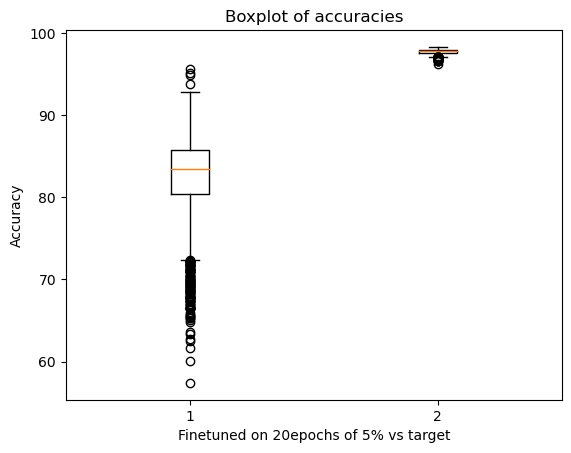

In [69]:
plt.boxplot(DF2[['reached test acc','target test acc']])
plt.xlabel('Finetuned on 20epochs of 5% vs target')
plt.ylabel('Accuracy')
plt.title('Boxplot of accuracies')
plt.show()

In [65]:
import warnings
warnings.filterwarnings('ignore')
Brain = CNN(1,"gelu",0,"kaiming_uniform")
task1=[7,1,9,3]
task2=[4,5]
task3=sorted(task1+task2)
L2=[x for x in range(10) if not (x in task3)]
model=copy.deepcopy(Brain)
#model.load_state_dict(checkpoint)

criterion_CNN0=CrossEntropyLoss()

test_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

_, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
if len(task3)==10:
    valid_epoch_acc1=valid_epoch_acc0
    #continue
else:
    criterion_CNN1=CrossEntropyLoss()
    test_IF1=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
    Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

#valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
#print("Reconstructed cnn acc ID",valid_epoch_acc0)
#print("Reconstructed cnn acc OOD",valid_epoch_acc1)
#DF.at[track,"Reconstructed Accuracy ID"]=valid_epoch_acc0

optimizerCNN = Adam(model.parameters(), lr=0.05)
schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
criterion_CNN=CrossEntropyLoss()


train_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
Tr_DLr = DataLoader(dataset=train_IF0, batch_size=150, num_workers=0, shuffle=True)


fine_tune_needed=0
#FINETUNING
# for epoch_cnn in range(8):
    # if epoch_cnn==0:
    #     train_epoch_loss, train_epoch_acc,_,images_needed= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,testloader=Ts_DL0,targetacc=90,df=None,First=True,verbose=True,log_freq_steps=10)
    #     valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
    # else:
    #      train_epoch_loss, train_epoch_acc,_,images_needed= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,df=None,First=False)
train_epoch_loss, train_epoch_acc,_,images_needed,d= train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,,epochs=8,testloader=Ts_DL0,targetacc=95,df=DF,First=False,verbose=True,log_freq_steps=100)
print(train_epoch_acc)

loaded 5.0 % of data for training
Train_acc  25.0 %
{0: 1, 1: 2, 4: 2, 5: 1, 3: 1, 2: 1}
Train_acc  45.66831683168317 %
{0: 144, 1: 140, 4: 138, 5: 134, 3: 127, 2: 125}


KeyboardInterrupt: 

In [66]:
images_needed

0

In [67]:
DF

,label task 1,label task 2,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,...,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch,step,images_needed,target test acc,reached test acc
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,100.0,8488.0,95.0,95.589454


In [68]:



skf = StratifiedKFold(n_splits=20)
print(len(Tr_DLr))
nb_images=0
d={}
for k,(image,label) in enumerate(Tr_DLr):
    if k ==(len(Tr_DLr)-1):
        continue
    else:
        print(label)
        for i, (train_index, test_index) in enumerate(skf.split(image,label)):
            if i==0:
                #print(f"batch {k} Fold {i}:")
                #print(f"  Train: index={train_index}")
                #print(f"  Test:  index={test_index}")
                #print(f"Added {label[train_index].shape[0]} to {nb_images} ")
                nb_images=nb_images+int(label[test_index].shape[0])
                d=add_dicts(d,count_elements(label[test_index]))
                #print("\t",count_elements(label[test_index]) )
        break
print(d)    

243
tensor([0, 0, 0, 5, 5, 5, 1, 4, 3, 2, 3, 2, 4, 5, 0, 3, 2, 3, 1, 4, 4, 0, 3, 5,
        0, 4, 4, 1, 2, 5, 2, 5, 0, 0, 3, 1, 3, 4, 2, 4, 2, 5, 0, 3, 2, 1, 4, 3,
        2, 1, 5, 3, 0, 0, 1, 1, 1, 5, 3, 2, 1, 3, 0, 1, 3, 2, 5, 4, 2, 3, 3, 4,
        4, 3, 1, 2, 1, 2, 1, 5, 3, 5, 5, 5, 3, 3, 0, 2, 4, 2, 3, 0, 2, 2, 4, 1,
        4, 5, 0, 2, 2, 4, 4, 4, 2, 5, 1, 1, 1, 5, 3, 2, 0, 4, 0, 2, 0, 5, 2, 2,
        5, 5, 0, 0, 1, 1, 4, 0, 3, 2, 1, 2, 1, 4, 4, 5, 0, 5, 0, 4, 1, 5, 1, 3,
        4, 0, 5, 4, 2, 2])
{0: 2, 5: 1, 1: 1, 4: 1, 3: 2, 2: 1}


In [70]:
Tr_DLr.classes

AttributeError: 'DataLoader' object has no attribute 'classes'

DataFrame Columns:
label task 1, label task 2, Reconstructed Accuracy ID, Transformer train Loss,
MSE, MSE 1, MSE 2, MSE 3, MSE 4, MSE 5, KL divergence, KL 1, KL 2, KL 3, KL 4,
KL 5, LWLN, Wasserstein Loss, WS 1, WS 2, WS 3, WS 4, WS 5, contractive
distance, N1, N11, N12, N13, N14, N15, N2, N21, N22, N23, N24, N25, saturated in
pred(%), saturated in GT(%), MSE FN, MSE 1 FN, MSE 2 FN, MSE 3 FN, MSE 4 FN, MSE
5 FN, KL divergence FN, KL 1 FN, KL 2 FN, KL 3 FN, KL 4 FN, KL 5 FN, LWLN FN,
Wasserstein Loss FN, WS 1 FN, WS 2 FN, WS 3 FN, WS 4 FN, WS 5 FN, contractive
distance FN, N1 FN, N11 FN, N12 FN, N13 FN, N14 FN, N15 FN, N2 FN, N21 FN, N22
FN, N23 FN, N24 FN, N25 FN, saturated in pred FN(%), saturated in GT FN(%), Step
0, Step 25, Step 50, Step 75, Step 100, Step 125, Step 150, Step 175, Step 200,
Step 225, Step 250, Step 275, epoch 0, epoch 1, epoch 2, epoch 3, epoch 4, epoch
5, epoch 6, epoch 7, KLD, WSD FN, Step 300, Step 325, Step 350


['Transformer train Loss', 'KL divergence', 'Wasserstein Loss FN', 'Step 175', 'Step 200', 'Step 225', 'Step 250', 'Step 275', 'Step 300', 'Step 325', 'Step 350']


,label task 1,label task 2,Reconstructed Accuracy ID,MSE,MSE 1,MSE 2,MSE 3,MSE 4,MSE 5,KL 1,...,epoch 0,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,KLD,WSD FN
0,"[0, 1, 4]","[2, 3, 7, 9]",15.816611,0.059849,0.090815,0.020668,0.187972,0.072846,0.147387,-0.154054,...,82.051282,90.816611,93.854515,95.512821,95.025084,96.934225,97.408027,97.812152,-0.129480,0.040971
1,"[0, 1, 2, 7]","[3, 4, 6, 8]",14.014076,0.056149,0.107440,0.025532,0.108438,0.064356,0.127357,-0.138734,...,81.368070,89.208544,92.332387,93.962218,95.048771,96.197061,96.802074,97.382393,-0.132474,0.038596
2,"[0, 6, 7]","[1, 2, 4, 5, 9]",14.159182,0.058576,0.108247,0.023896,0.106276,0.079141,0.113359,-0.145301,...,81.761477,89.533433,93.774950,94.748004,96.581836,97.118263,96.993513,97.891717,-0.127410,0.024045
3,"[2, 3, 6, 7]","[4, 5, 9]",14.614383,0.052633,0.088196,0.020233,0.100144,0.069295,0.122138,-0.142211,...,68.094342,82.592968,88.974099,92.779627,95.470988,96.006367,96.889018,96.773260,-0.130036,0.039055
4,"[0, 3, 8]","[1, 2, 9]",18.485342,0.054480,0.103109,0.022407,0.096208,0.069576,0.117440,-0.145754,...,74.690554,89.169381,92.703583,95.488599,96.710098,97.166124,97.524430,98.110749,-0.130461,0.034850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467,"[0, 2, 3]","[1, 5]",22.479699,0.047516,0.082551,0.018616,0.100706,0.060279,0.108480,-0.146430,...,72.053872,90.711032,94.612795,95.820955,97.167756,97.583680,98.019410,97.880768,-0.129598,0.032755
3468,"[0, 1, 6, 9]","[2, 4]",18.618766,0.056987,0.116967,0.023772,0.100319,0.069120,0.124941,-0.151618,...,81.676509,90.157480,93.471129,94.767060,96.161417,96.948819,97.539370,98.179134,-0.130206,0.029369
3469,"[0, 2, 3, 4]","[1, 5, 9]",16.122159,0.053679,0.100498,0.021571,0.091266,0.066062,0.130169,-0.142369,...,77.840909,89.090909,93.551136,93.948864,96.335227,96.732955,97.230114,97.471591,-0.132558,0.040793
3470,"[1, 5, 8]","[2, 4, 6]",17.277750,0.054368,0.095036,0.023929,0.103663,0.068597,0.115284,-0.147187,...,64.071656,90.306379,94.642558,95.379206,96.936213,97.036665,97.806797,98.007701,-0.132195,0.041353


[]

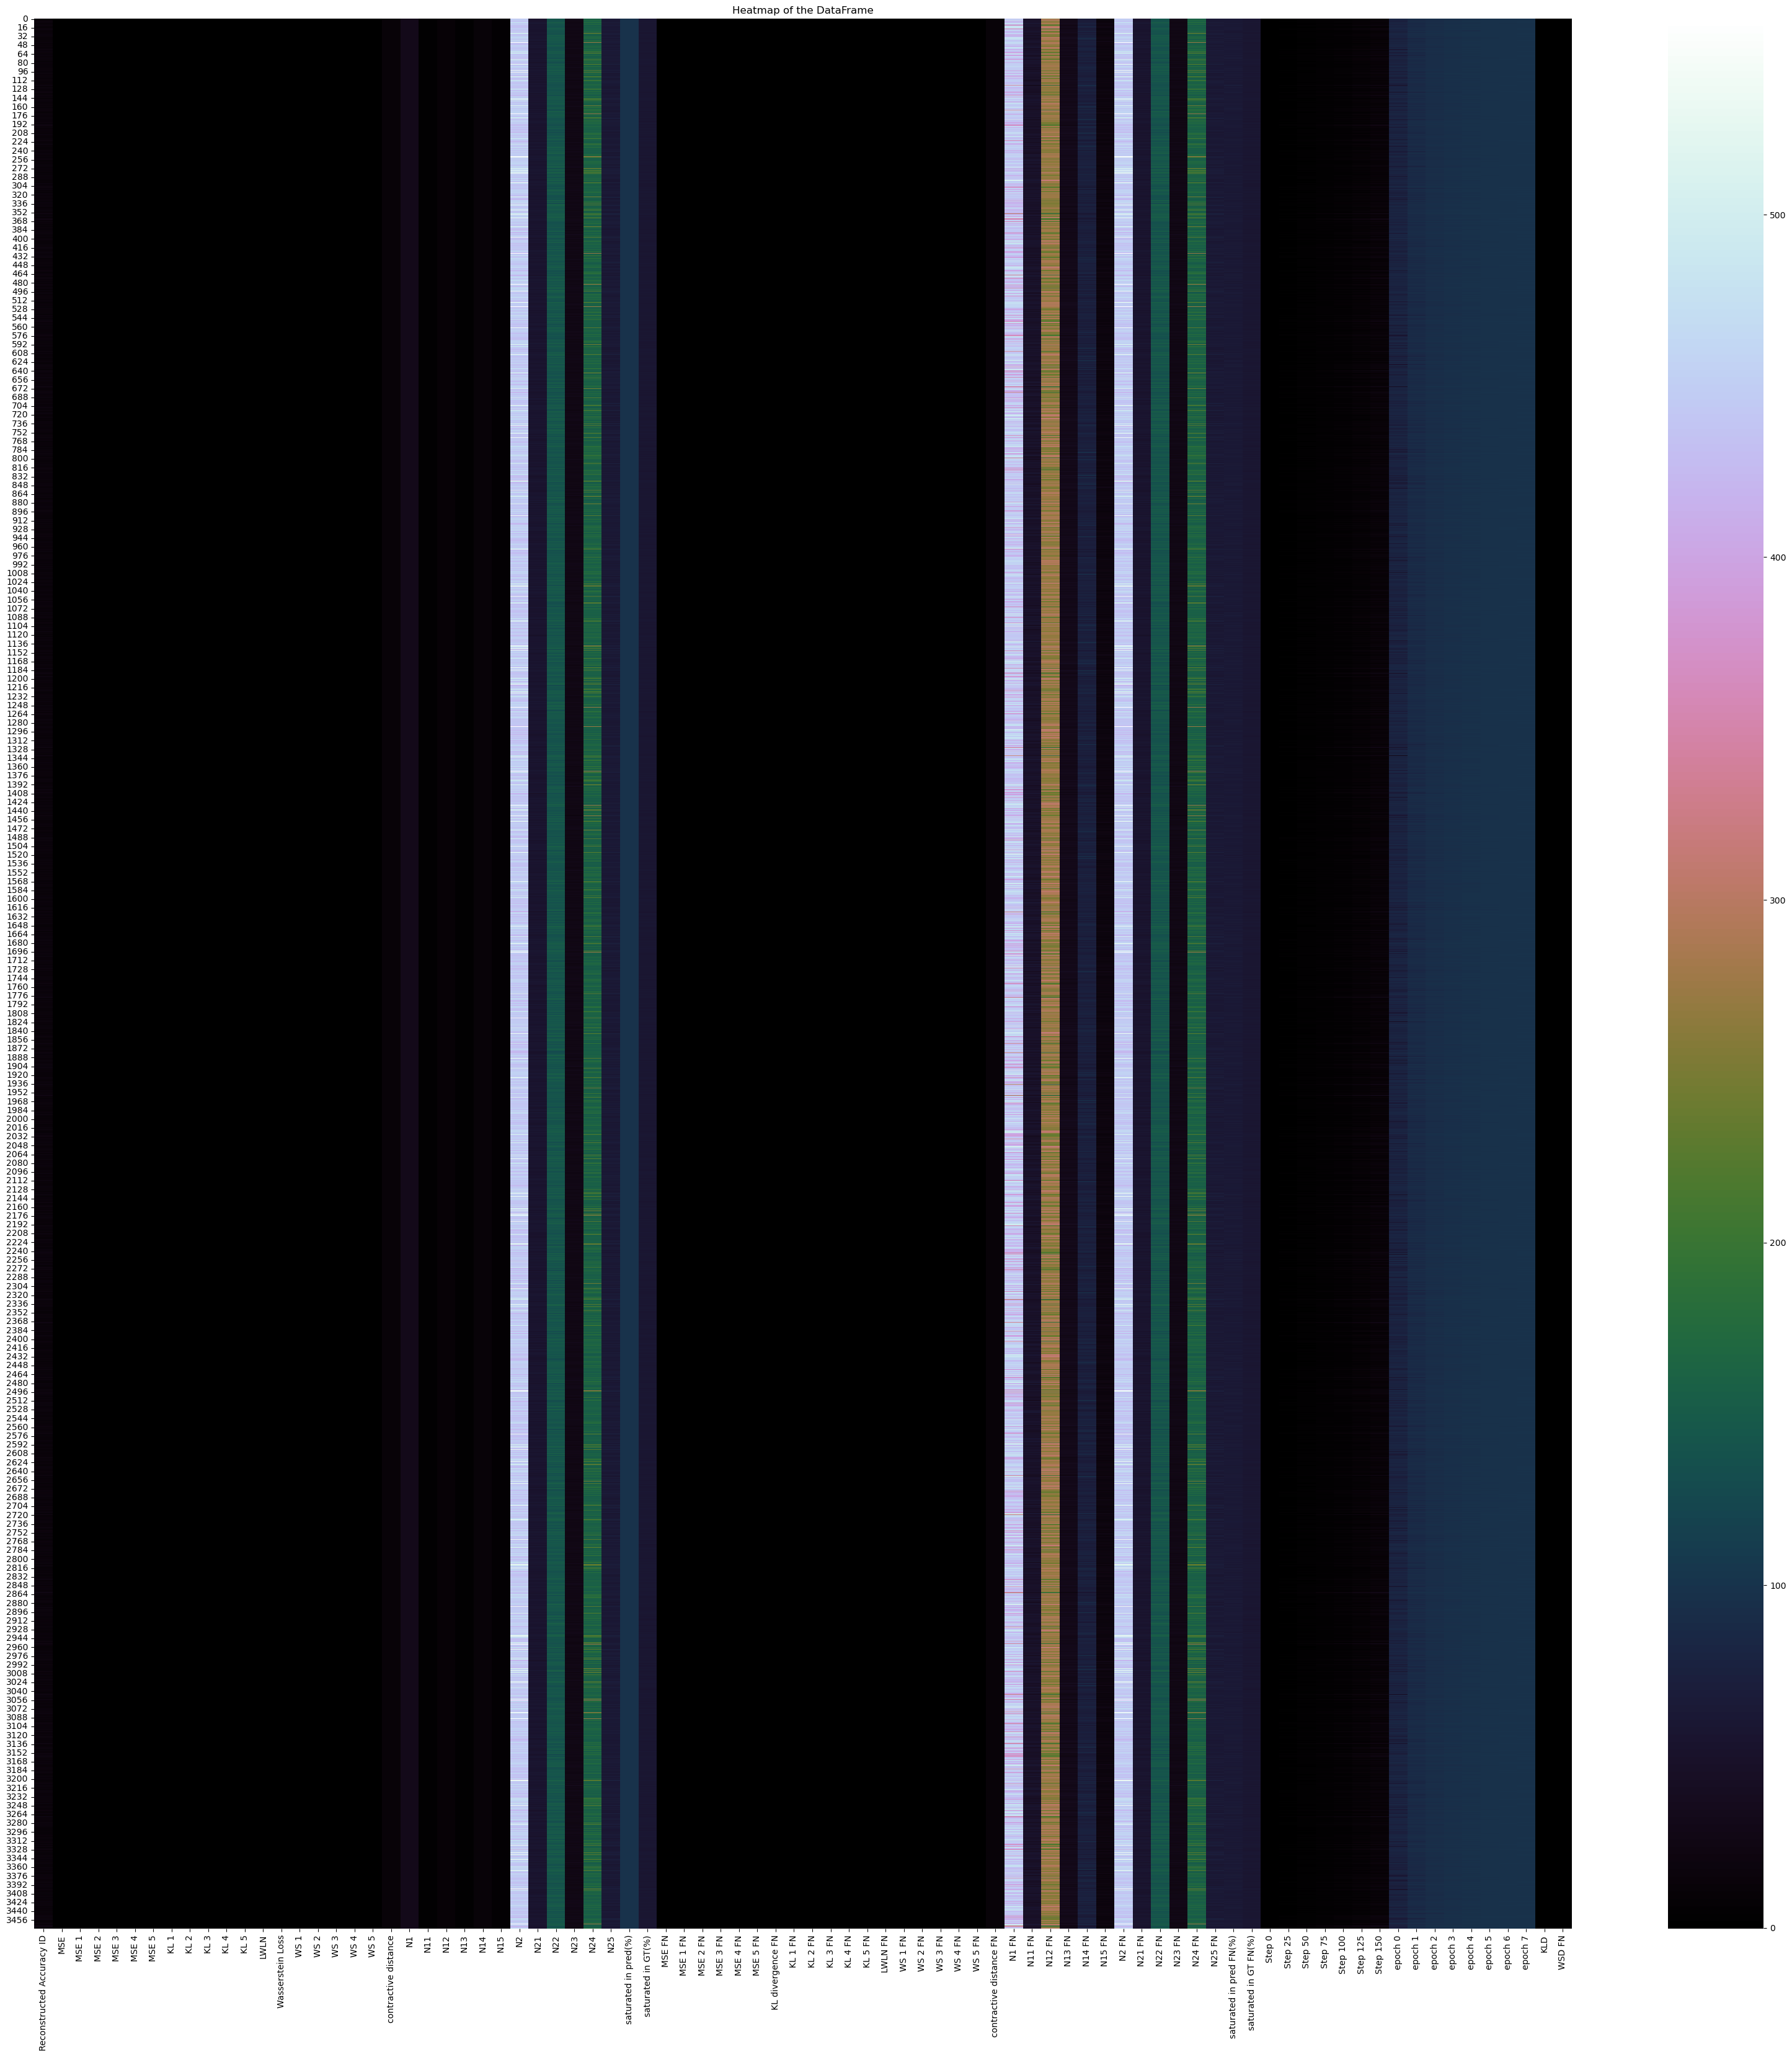

In [83]:
#!pip install -U giotto-tda

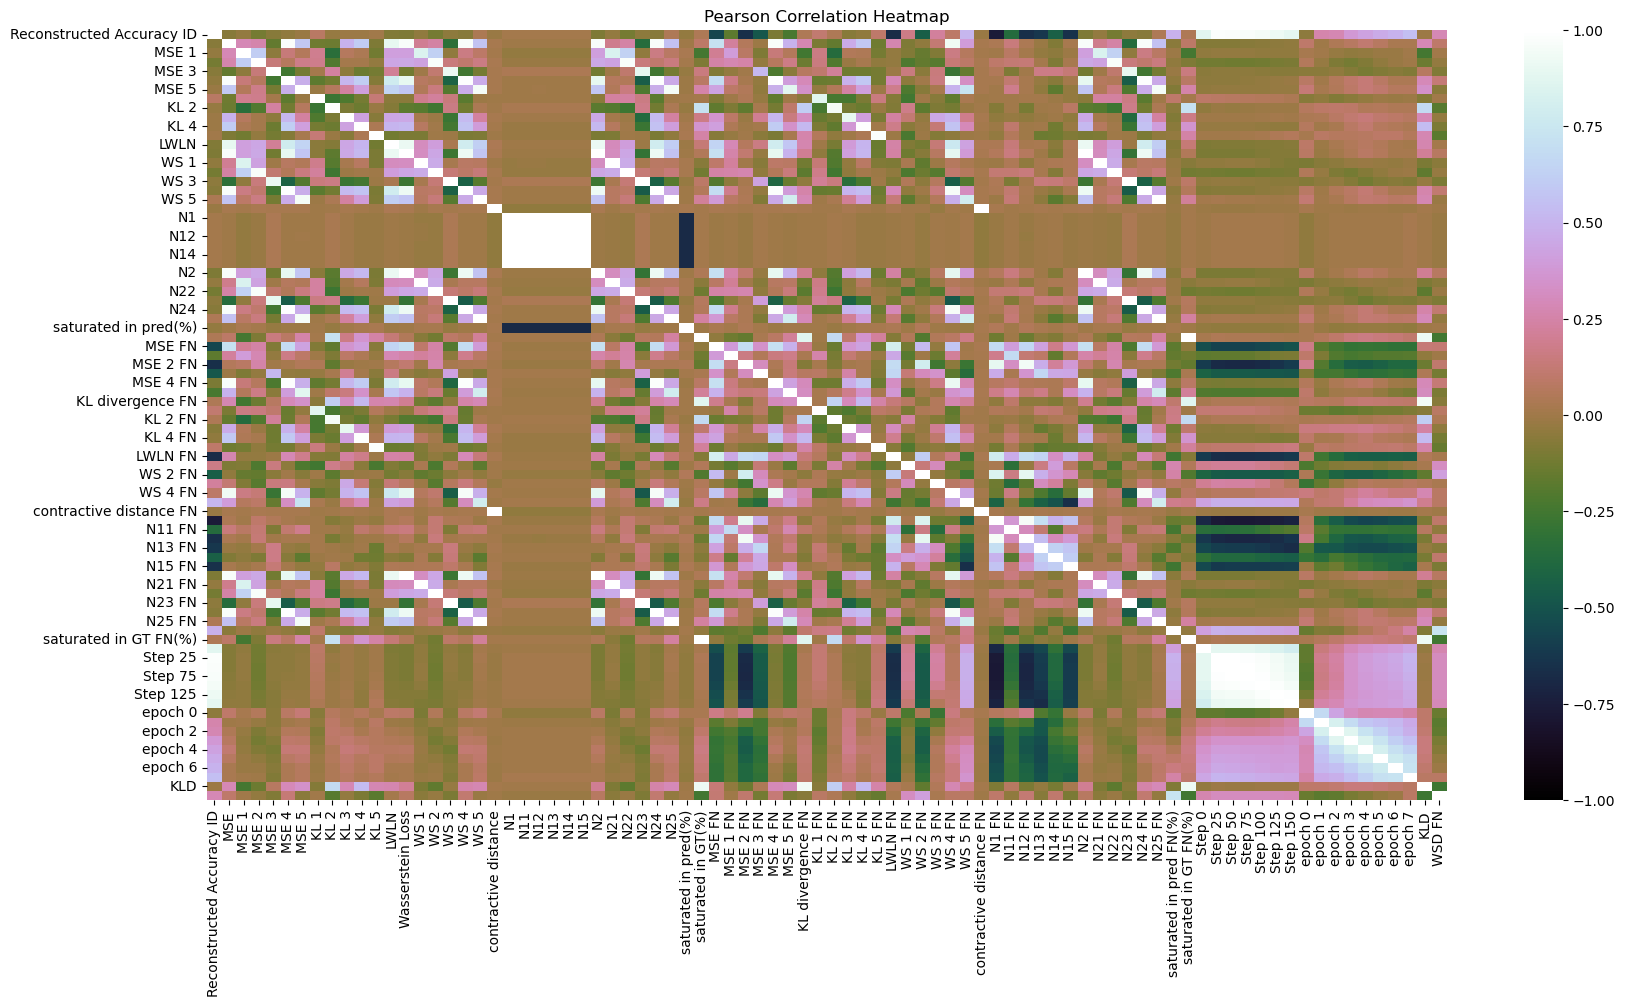

In [85]:
corr_matrix

,Reconstructed Accuracy ID,MSE,MSE 1,MSE 2,MSE 3,MSE 4,MSE 5,KL 1,KL 2,KL 3,...,epoch 0,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,KLD,WSD FN
Reconstructed Accuracy ID,1.000000,-0.063379,-0.031784,-0.115829,-0.065826,-0.043087,-0.023429,0.080721,-0.027651,-0.013227,...,-0.051782,0.264397,0.280780,0.381735,0.429166,0.461931,0.495066,0.552717,-0.010828,0.284128
MSE,-0.063379,1.000000,0.281901,0.263176,-0.158734,0.970531,0.587645,-0.125173,-0.136193,0.499773,...,0.098268,-0.001066,0.041197,0.075842,0.110863,0.075859,0.028912,0.030540,0.282507,0.096575
MSE 1,-0.031784,0.281901,1.000000,0.614952,-0.050862,0.134914,0.056494,0.187592,-0.343546,0.068787,...,0.020290,0.005960,-0.026935,-0.039537,-0.031273,-0.020980,-0.019297,0.002948,-0.246758,0.007317
MSE 2,-0.115829,0.263176,0.614952,1.000000,0.139436,0.065767,0.173226,0.181060,-0.205868,0.011060,...,0.062338,-0.025770,-0.088132,-0.116657,-0.083555,-0.042273,-0.020829,-0.007566,-0.133673,-0.035133
MSE 3,-0.065826,-0.158734,-0.050862,0.139436,1.000000,-0.251778,-0.112522,0.013532,0.227453,-0.047342,...,-0.061547,-0.059102,-0.041257,-0.072755,-0.106529,-0.078787,-0.069696,-0.084163,0.076353,-0.084488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
epoch 5,0.461931,0.075859,-0.020980,-0.042273,-0.078787,0.082178,0.105115,-0.013263,0.058999,0.108941,...,0.285758,0.550961,0.635889,0.731550,0.808021,1.000000,0.771693,0.705340,0.128762,-0.037641
epoch 6,0.495066,0.028912,-0.019297,-0.020829,-0.069696,0.031848,0.069244,-0.018225,0.046398,0.093677,...,0.282630,0.516914,0.547027,0.621362,0.705841,0.771693,1.000000,0.725328,0.103915,-0.009163
epoch 7,0.552717,0.030540,0.002948,-0.007566,-0.084163,0.031980,0.062626,-0.012094,0.040935,0.077750,...,0.242778,0.459556,0.477017,0.552466,0.629774,0.705340,0.725328,1.000000,0.083730,0.081284
KLD,-0.010828,0.282507,-0.246758,-0.133673,0.076353,0.296242,0.341149,-0.071196,0.678647,0.286789,...,0.096943,0.099194,0.112010,0.145766,0.147862,0.128762,0.103915,0.083730,1.000000,-0.270269


,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,weight 8,weight 9,...,bias 2454,bias 2455,bias 2456,bias 2457,bias 2458,bias 2459,bias 2460,bias 2461,bias 2462,bias 2463
0,0.387808,0.372654,0.151352,-0.105807,-0.082500,-0.238170,0.195475,0.178348,0.341529,0.263371,...,0.168370,0.184046,-0.123804,0.013633,0.084517,0.114631,-0.186843,0.068980,-0.117690,0.105709
1,-0.212145,0.070784,-0.079969,0.213956,0.457800,-0.291359,-0.539251,-0.095598,-0.242432,0.607016,...,0.079871,0.059650,-0.044894,0.143082,-0.069287,0.278303,-0.268586,0.141068,-0.021933,-0.054747
2,-0.241022,-0.108913,0.019223,0.198406,-0.252828,0.156529,0.289441,0.080319,0.147019,0.202009,...,-0.097850,0.274446,-0.216636,-0.206452,-0.077477,0.182121,-0.042414,0.197808,0.099291,0.028916
3,-0.113218,0.026529,0.060565,0.428265,0.054305,-0.245629,0.427403,0.335008,0.319047,0.590981,...,0.181532,0.198966,0.117551,-0.081446,-0.217298,0.015922,-0.230746,0.396043,-0.138373,-0.129584
4,0.438483,-0.068645,0.060519,-0.660716,-0.566601,0.453559,-0.064753,-0.178230,-0.568970,-0.330471,...,-0.087359,-0.005138,-0.104317,0.030210,0.093524,0.051870,0.061928,0.133377,-0.124248,0.062188


In [129]:
df=DF

In [154]:
results=DF[Cols[7394:]]
results

,Actual Accuracy,Reconstructed Accuracy ID,Transformer train Loss,MSE,MSE 1,MSE 2,MSE 3,MSE 4,MSE 5,KLD,...,Step 250,Step 275,epoch 0,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7
0,97.041667,15.816611,266.413391,0.093660,0.157904,0.032264,0.276309,0.109396,0.240182,-0.128826,...,63.162812,71.224013,93.840580,95.680045,96.711260,97.575251,97.672798,97.826087,97.770346,98.104794
1,97.818333,14.014076,NaN,0.090652,0.157545,0.039850,0.182015,0.105601,0.219957,-0.131839,...,54.110631,61.126876,93.283121,96.147673,96.913199,97.481171,97.789851,97.925670,98.061489,98.246697
2,97.815000,14.159182,NaN,0.093372,0.166291,0.035709,0.175504,0.120211,0.218618,-0.126514,...,51.820151,58.769628,90.543912,95.521457,96.768962,97.005988,97.330339,97.704591,97.854291,97.891717
3,97.808333,14.267110,NaN,0.085224,0.154899,0.032270,0.144285,0.110544,0.202967,-0.129505,...,57.050911,65.307106,92.331066,94.530459,96.353639,96.845608,97.453335,97.294169,97.887426,98.220229
4,97.926667,18.485342,NaN,0.085674,0.172058,0.033909,0.132739,0.113467,0.177038,-0.130440,...,NaN,NaN,92.459283,95.993485,96.856678,96.986971,97.850163,98.094463,98.355049,98.387622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467,98.048333,22.479699,NaN,0.080115,0.152176,0.029490,0.154481,0.101825,0.187557,-0.129539,...,NaN,NaN,93.780947,96.454744,97.544068,98.237275,98.534363,98.573975,98.791840,98.950287
3468,97.450000,18.618766,NaN,0.088023,0.129858,0.038200,0.145907,0.117326,0.201886,-0.130449,...,NaN,NaN,94.553806,96.571522,97.473753,98.015092,98.523622,98.507218,98.605643,98.900919
3469,97.453333,16.122159,NaN,0.089763,0.156127,0.034713,0.146651,0.112749,0.232087,-0.131478,...,65.209932,73.440404,93.536932,95.980114,97.088068,97.500000,97.869318,97.926136,98.551136,98.437500
3470,97.815000,17.277750,NaN,0.091730,0.151859,0.037858,0.141446,0.115175,0.235261,-0.130933,...,NaN,NaN,94.341202,96.634857,97.488699,97.773313,98.359283,98.560188,98.794576,98.727608


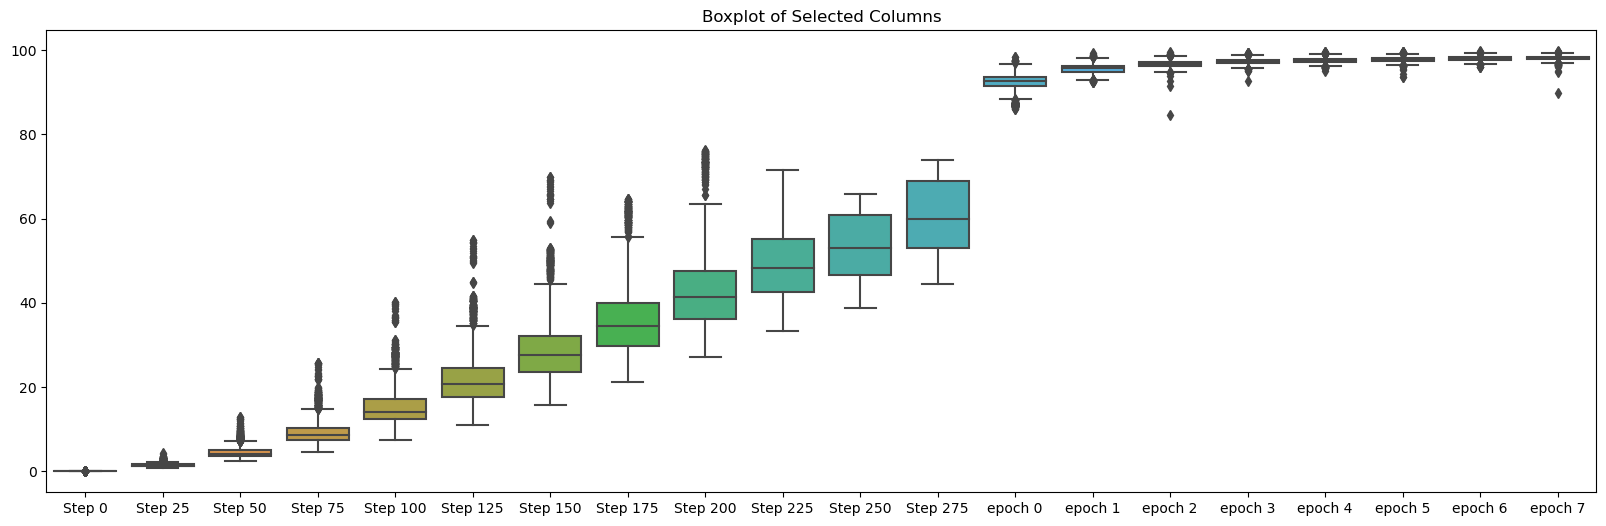

In [155]:
import seaborn as sns
#DF=df

# ["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
# ["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KL divergence","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
# ["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
# ["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
# ["Wasserstein Loss FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\
# ["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
# ["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]

columns_to_plot = ["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]

# Plotting the boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(data=DF[columns_to_plot])
plt.title('Boxplot of Selected Columns')
plt.show()

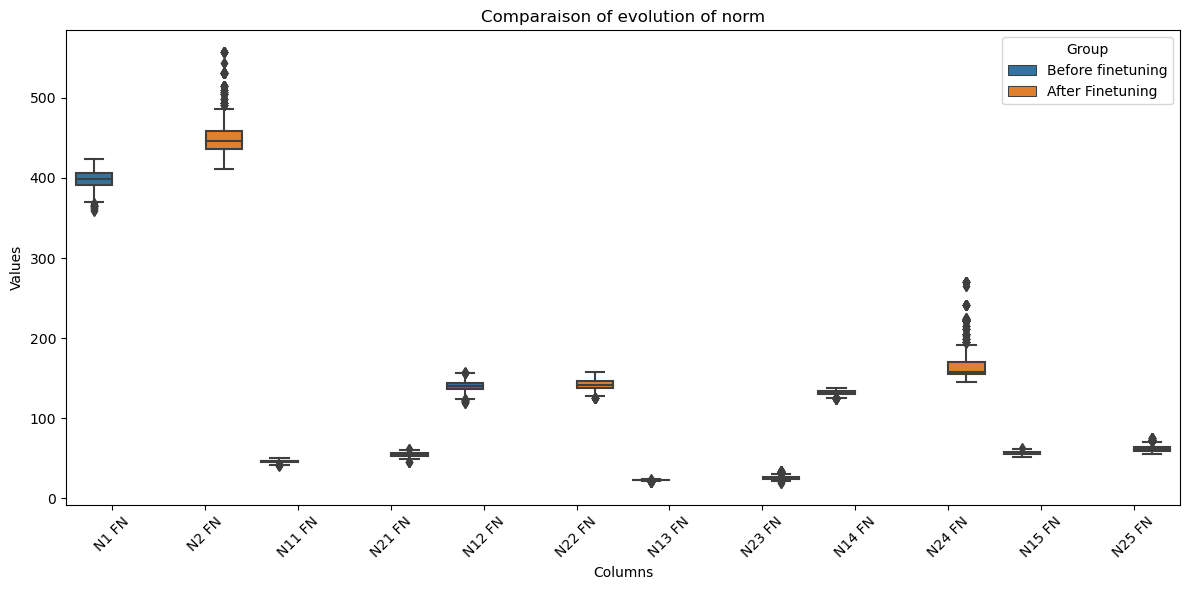

In [156]:
# Define groups of columns
#df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN"]
group2_columns = ["N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN"]

# Create a long-format DataFrame for seaborn
group1_melted = df[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = df[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(6):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of evolution of norm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
# ["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
# ["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KL divergence","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
# ["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
# ["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
# ["Wasserstein Loss FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\

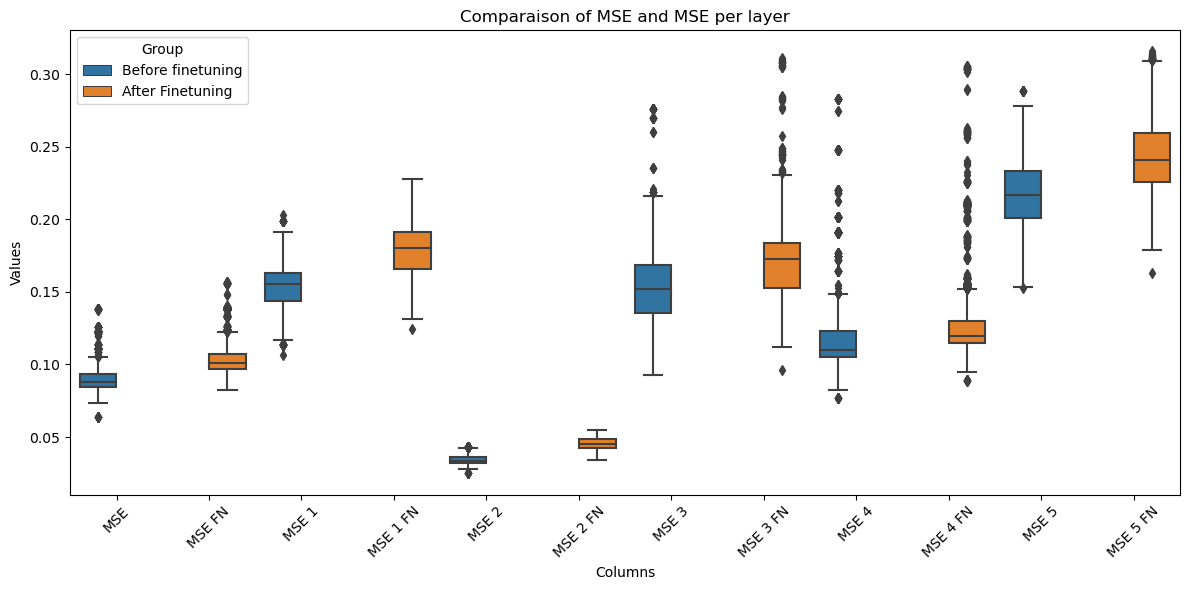

In [158]:
# Define groups of columns
#df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5"]
group2_columns = ["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(6):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of MSE and MSE per layer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

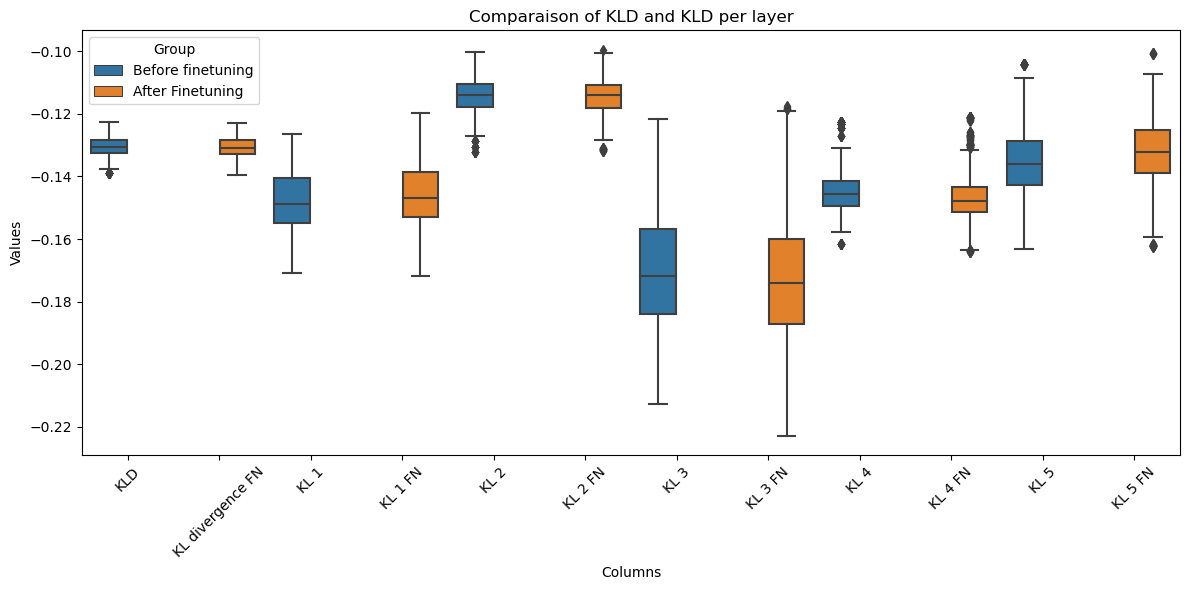

In [159]:
# Define groups of columns
df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["KLD","KL 1","KL 2","KL 3","KL 4","KL 5"]
group2_columns = ["KL divergence FN" ,"KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(6):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of KLD and KLD per layer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

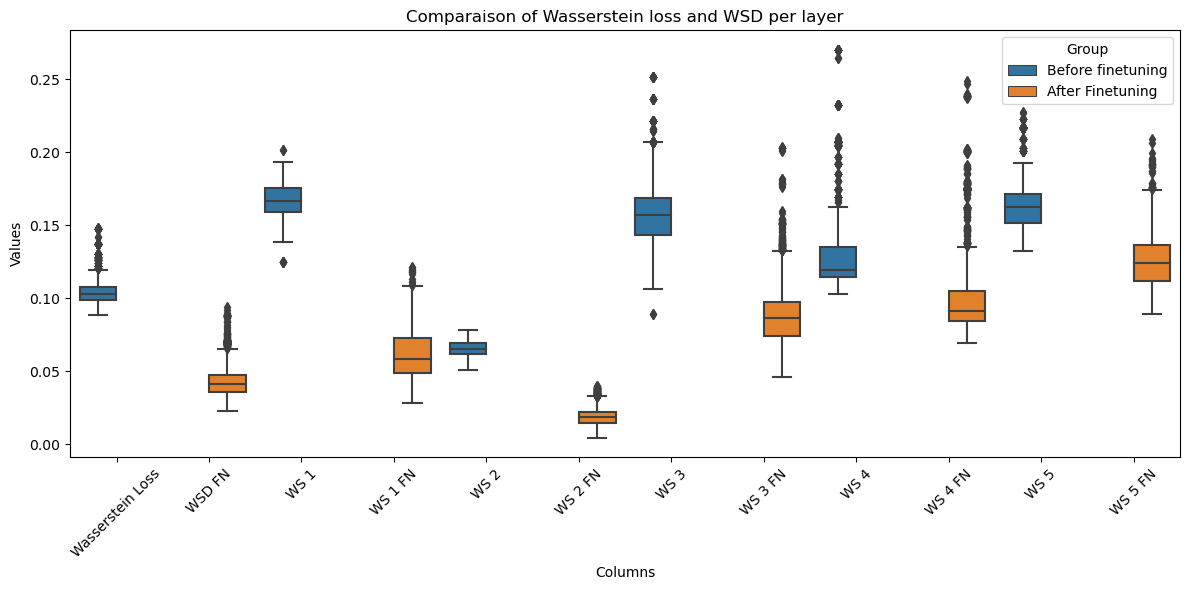

In [137]:
# Define groups of columns
df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5"]
group2_columns = ["WSD FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN" ]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(6):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of Wasserstein loss and WSD per layer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

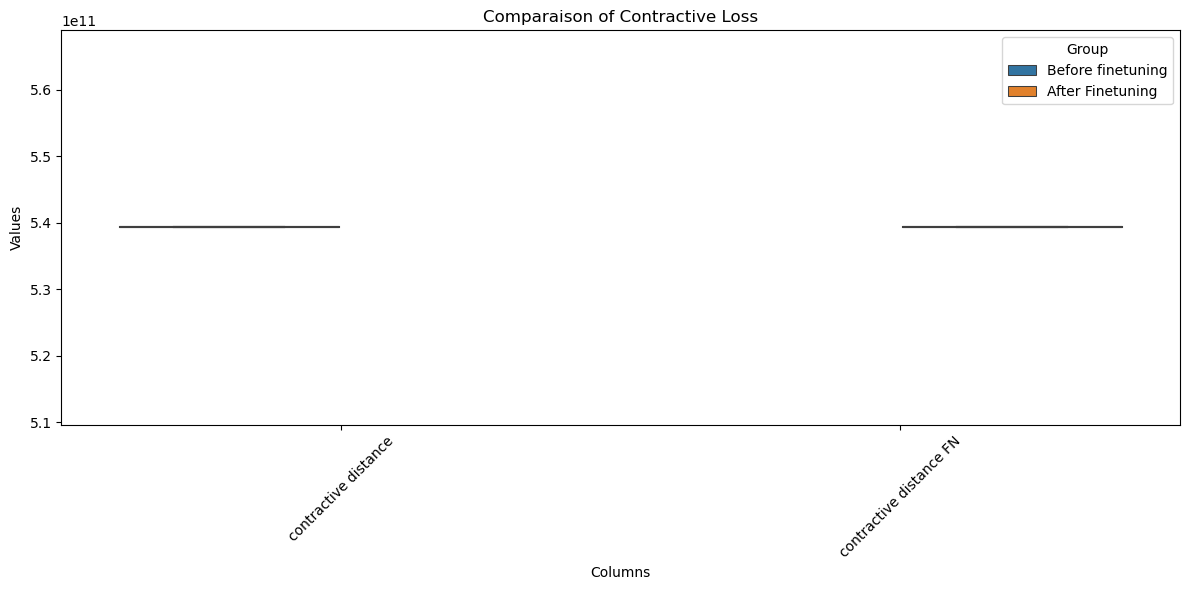

In [160]:
# Define groups of columns
#df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["contractive distance"]
group2_columns = ["contractive distance FN"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(1):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of Contractive Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

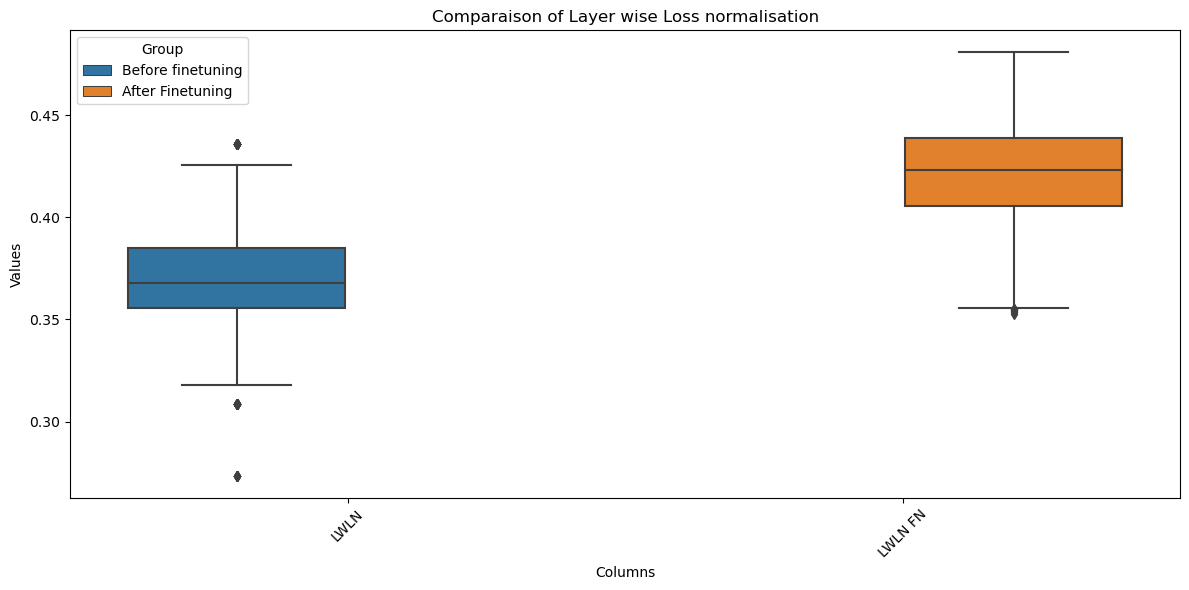

In [161]:
# Define groups of columns
df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["LWLN"]
group2_columns = ["LWLN FN"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(1):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of Layer wise Loss normalisation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

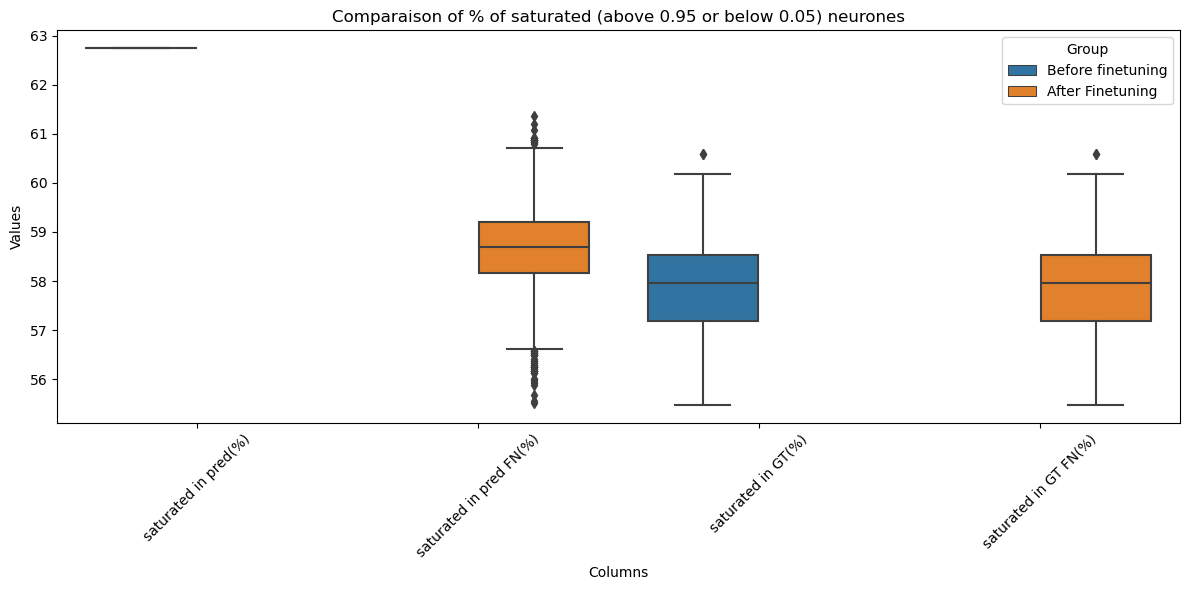

In [162]:
# Define groups of columns
#df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["saturated in pred(%)","saturated in GT(%)"]
group2_columns = ["saturated in pred FN(%)","saturated in GT FN(%)"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Before finetuning'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'After Finetuning'


# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Create a custom order for columns to interleave the groups
custom_order=[]
for i in range(2):
    custom_order.append(group1_columns[i])
    custom_order.append(group2_columns[i])
melted_df['Columns'] = pd.Categorical(melted_df['Columns'], categories=custom_order, ordered=True)

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of % of saturated (above 0.95 or below 0.05) neurones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
EXP[40][0]

[0, 1, 5, 7]

In [ ]:
 if (i in [nb_batches-1] and (epoch%5==0)) or (i==0 and epoch==0):
            
            
            #print(f"Validating ... {loss_val}")
            for vect in [0,10,40,50,70]:
                y_pred=torch.unsqueeze(output[0][vect], 0) 
                y =torch.unsqueeze(tg[vect], 0) 

                selected_row = cs_tr.df.iloc[int(U[vect][0]), 11:17]  
                columns_with_one = selected_row[selected_row == 1].index.tolist()
                activ=columns_with_one
                epochCNN=cs_tr.df.loc[int(U[vect][0])]['epoch']


                checkpoint=OrderedDict()
                vector_aux= output[0][vect].detach()
                y_pred=vector_aux.cpu()

                task1=[int(x) for x in EXP[vect][0]]
                task2=[int(x) for x in EXP[vect][1]]
                task3=sorted(task1+task2)


                All=list(range(10))
                L2=[k for k in All if k not in task3] # Out of distribution classes
                L_others=[k for k in All if k not in task3] #Classes to test on (In distribution)

                checkpoint["module_list.0.weight"]=torch.tensor(np.array(y_pred[0:200]).reshape([8, 1, 5, 5]))
                checkpoint["module_list.0.bias"]=torch.tensor(np.array(y_pred[200:208]).reshape([8]))

                checkpoint["module_list.3.weight"]=torch.tensor(np.array(y_pred[208:1408]).reshape([6, 8, 5, 5]))
                checkpoint["module_list.3.bias"]=torch.tensor(np.array(y_pred[1408:1414]).reshape([6]))

                checkpoint["module_list.6.weight"]=torch.tensor(np.array(y_pred[1414:1510]).reshape([4, 6, 2, 2]))
                checkpoint["module_list.6.bias"]=torch.tensor(np.array(y_pred[1510:1514]).reshape([4]))

                checkpoint["module_list.9.weight"]=torch.tensor(np.array(y_pred[1514:2234]).reshape([20,36]))
                checkpoint["module_list.9.bias"]=torch.tensor(np.array(y_pred[2234:2254]).reshape([20]))

                checkpoint["module_list.11.weight"]=torch.tensor(np.array(y_pred[2254:2454]).reshape([10,20]))
                checkpoint["module_list.11.bias"]=torch.tensor(np.array(y_pred[2454:2464]).reshape([10]))

                Brain = CNN(1,activ[0],0,"kaiming_uniform")

                model=copy.deepcopy(Brain)
                model.load_state_dict(checkpoint)

                criterion_CNN0=CrossEntropyLoss()

                test_IF0=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

                _, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
                if len(task3)==10:
                    valid_epoch_acc1=valid_epoch_acc0
                    continue
                else:
                    criterion_CNN1=CrossEntropyLoss()
                    test_IF1=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                    Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

                valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
                cnn_acc_ID.append(valid_epoch_acc0)
                cnn_acc_OOD.append(valid_epoch_acc1)
                #lr = optimizer.param_groups[0]["lr"]
                lrE1=optimizerEnc1.param_groups[0]["lr"]
                lrE2=optimizerEnc2.param_groups[0]["lr"]
                lrL=optimizerDense.param_groups[0]["lr"]
                lrD=optimizerDec.param_groups[0]["lr"]
                
                
                
            #print(f"Reconstructing ... {valid_epoch_acc0}")
                optimizerCNN = Adam(model.parameters(), lr=0.05)
                schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
                criterion_CNN=CrossEntropyLoss()
                
                
                train_IF0=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Tr_DLr = DataLoader(dataset=train_IF0, batch_size=100, num_workers=0, shuffle=True)
                
                
                wandb.define_metric(f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_loss train {task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_acc train{task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                
                wandb.define_metric(f"[{epoch}]CNN_fn_loss test {task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_acc test{task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                fine_tune_needed=0
                #print(task1,task2,task3)
                for epoch_cnn in range(15):
                    
                    # for param in model.parameters():
                    #     print(f"Param before step: {param.data[0]}")
                    #     break
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    schedulerCNN.step()
                    # for param in model.parameters():
                    #     print(f"Param after step: {param.data[0]}")
                    #     break
                    fine_tune_needed+=1
                    #if fine_tune_needed%5==0:
                        #print(f"Accuracy of {train_epoch_acc:.2f} / ACC[vect][2] after {fine_tune_needed} epochs")
                    wandb.log({f"[{epoch}]CNN_fn_loss train {task1}{task2}{task3}":train_epoch_loss,f"[{epoch}]CNN_fn_acc train {task1}{task2}{task3}":train_epoch_acc , f"finetune_step for epoch {epoch}": fine_tune_needed})
                    wandb.log({f"[{epoch}]CNN_fn_loss test {task1}{task2}{task3}":valid_epoch_loss0FN,f"[{epoch}]CNN_fn_acc test {task1}{task2}{task3}":valid_epoch_acc0FN , f"finetune_step for epoch {epoch}": fine_tune_needed})
                    
                          
                    wandb.log({f"[{epoch}]finetune ratio {task1}{task2}{task3}":valid_epoch_acc0FN/ACC[vect][2], f"finetune_step for epoch {epoch}": fine_tune_needed})
                    wandb.log({f"combined target accuracy {task1}{task2}{task3}":ACC[vect][2], f"finetune_step for epoch {epoch}": fine_tune_needed})
                # define our custom x axis metric

            
        wandb.log({"Loss":loss_to_save})
        wandb.log({"CNN_IID_no_fine_tune":(np.mean(cnn_acc_ID))})
        wandb.log({"CNN_OOD_no_fine_tune":(np.mean(cnn_acc_OOD))})
        wandb.log({"lr Encoder 1": lrE1,"lr Encoder 2": lrE2,"lr Linear": lrL,"lr Decoder": lrD})

In [ ]:
result

In [ ]:
plt.figure(figsize=(10, 8))
hm=sns.heatmap(torch.mean( torch.mean(output[4][-1], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
plt.title('Attention Heatmap')

heatmap_path = f'heatmap 1 _step_{0}.svg'
plt.savefig(heatmap_path,format='svg', dpi=800)
plt.close()

#wandb.log({"attention_heatmap 1": wandb.Image(heatmap_path)})

In [ ]:
#https://discuss.pytorch.org/t/memory-management-using-pytorch-cuda-alloc-conf/157850
#https://stackoverflow.com/questions/73747731/runtimeerror-cuda-out-of-memory-how-can-i-set-max-split-size-mb

import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))